In [1586]:
import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as ptchs
from matplotlib import gridspec
import matplotlib.text as mtext

import scipy.integrate
import scipy.optimize
from sklearn.linear_model import Ridge

import pandas as pd
from pandas.core.base import PandasObject

pred_color ="k"
pred_style = {"marker": "s", "color":pred_color, "markersize":7, "markerfacecolor":'none'}
pred_nocolor_style = {"marker": "s", "markersize":7, "markerfacecolor":'none'}
sum_style = {"marker": "s", "markersize":7, "ls":":"}
bm_style = {"marker": "s", "markersize":5}
vd_style = {"marker": "s", "markersize":7}
sl_style = {"marker": "o", "color":"k", "ms":14, "markerfacecolor":"None"}

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color'] 
ecolors=["b", "r", "g", "brown"]
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

# import mplhep as hep
# hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, r'\textbf{' + orig_handle + '}', usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

class LightLegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LightLegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

def fill_between_edges(ax, X, ymin, ymax, facecolor, edgecolor, label="", **kwargs):
    ax.fill_between(X, ymin, ymax, alpha=0.8, color=facecolor, **kwargs)
    ax.fill_between(X, ymin, ymax, facecolor="none", edgecolors=edgecolor, **kwargs)
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=facecolor, edgecolor=edgecolor, label=label))

In [1587]:
class MinorSymLogLocator(ticker.Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

In [1588]:
def convert_to_type(df, col, type):
    df[col] =  df[col].apply(lambda s: type(s) if pd.notnull(s) else s)

def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

def unique_non_nan(df):
    return df.dropna().unique()
PandasObject.unique_non_nan = unique_non_nan

def map_distr_name(distr):
    s = distr.split("-")
    n = distr
    if "constant" in distr:
        n = f"{s[0]}({s[1]})"
    elif "normal" in distr:
        n = f"{s[0]}({s[1]}, {s[2]})"
    return n.title()

def human_readable(val, bytes=False):
    factor = 1024 if bytes else 1e3
    if int(val/pow(factor, 3)) > 0:
        return f"{int(val/pow(factor, 3))}B"
    elif int(val/pow(factor, 2)) > 0:
        return f"{int(val/pow(factor, 2))}M"
    elif int(val/pow(factor, 1)) > 0:
        return f"{int(val/pow(factor, 1))}K"
    else:
        return str(int(val))
        
def convert_unit(x):
    """
    Get factor to convert to seconds
    """
    if x == "s":
        return 1
    elif x == "ms":
        return 1e3
    elif x == "us":
        return 1e6
    elif x == "ns":
        return 1e9

def unit_to_unit_factor(u1, u2):
    f1 = convert_unit(u1)
    f2 = convert_unit(u2)
    return f2/f1

def map_env(e):
    if e == "CUDA_HIST":
        return "CUDA"
    elif e == "AdaptiveCpp": 
        return "ACPP"
    return e

def mae(pred, observ):
    return np.sum(np.abs(pred-observ))/len(pred)

def r2(pred, observ):
    return 1- (np.sum(np.power(pred-observ, 2)) / np.sum(np.power(observ - np.mean(observ), 2)))

In [1589]:
def lower_bound(a, v):
    first = 0
    count = len(a)
    last = count - 1
    acc = np.zeros(len(a))
    indices = []
        
    while count > 0:
        it = first
        step = int(count / 2)
        it += step

        acc[it] += 1
        indices.append(it)
            
        if a[it] < v:
            it += 1
            first = it
            count -= step + 1
        else:
            count = step
    return first, acc, indices
    
def get_subsize(distr, nbins):
    """
    Calculate  based on the distribution type and number of bins.

    Parameters:
    - distr (str): The distribution type, e.g., "constant", "uniform", or "normal-mu-sigma".
    - nbins (int, list): Number of bins or a list of bin counts for which subsize needs to be calculated.

    Returns:
    - subsize (int, list): Calculated subsize based on the distribution type and number of bins.

    Notes:
    - If distr is "constant", subsize is an array of 1s with the same length as nbins.
    - If distr is "uniform", subsize is a list if nbins is a list, otherwise, it's an array of nbins.
    - If distr is "normal-mu-sigma", subsize is calculated based on the normal distribution with mean (mu) and
      standard deviation (sigma). If nbins is a list, it calculates subsize for each bin count in the list.
    """
    if "constant" in distr:       
        subsize = np.power(nbins, 0)
    elif "uniform" in distr:
        subsize = nbins
    elif "normal" in distr:
        mu = np.float64(distr.split("-")[1])
        sigma = np.float64(distr.split("-")[2])
        xmin = mu - 2*sigma
        xmax = mu + 2*sigma
        subsize = []
        try:
            for nb in nbins:
                a = np.arange(nb)/nb
                subsize.append(lower_bound(a, xmax)[0] - lower_bound(a, xmin)[0])
        except:
            a = np.arange(nbins)/nbins
            subsize = lower_bound(a, xmax)[0] - lower_bound(a, xmin)[0]
    return subsize

In [1590]:
def filter_name(n):
    # print(n)
    name_map = {
        "Stats" : "UpdateStats",
        "Reduce" : "UpdateStats",
        "Histo" : "FindBin + AddBinContent",
        "ExcludeUOverflowKernel" : "Other",
        "InitializeToZeroTask" : "Other",
        "Host-to-Device" : "HtoD",
        "Device-to-Host" : "DtoH",
        "CUDAmemset" : "Memset",
    }
    for w in ["unsigned", "int", "char", "float", "void", "const", "long", "*", "hipsycl_kernel",
              "::operator", "ROOT::", "Experimental::", "_", "::", "]", "[", "  "]:
        n = n.replace(w, "")
    for k,v in name_map.items():
        if k in n:
            n = v

    return n.strip()

def get_cell(df, index_name, col):
    return df.loc[index_name][col]
    
def fill_bar(h, x, w, d, c, s):
    h.Fill(x, w)
    h.SetBinError(h.FindBin(x), d)
    if s:
        h.SetFillStyle(s)
    h.SetLineColor(c)
    h.SetFillColor(c)
    h.SetLineWidth(2)
    h.SetMarkerSize(0)

# default_clr = ROOT.kGray+2
def get_group(n):
    if n in [
        "cuModuleLoadDataEx",
        "cuModuleUnload",
        "cuModuleGetLoadingMode",
        "cuCtxSetCurrent",
    ]:
        return "Module"
    elif n in [
        "cuEventCreate",
        "cuEventDestroy_v2",
        "cuEventQuery",
        "cuEventRecord",
        "cuEventSynchronize",
        "cudaEventCreate",
        "cudaEventDestroy",
        "cudaEventRecord",
        "cudaEventSynchronize",
    ]:
        return "Event"
    elif n in [
        "cuMemAlloc_v2",
        "cuMemFree_v2",
        "cuMemcpyAsync",
        "cuMemcpyHtoDAsync_v2",
        "cuMemcpyDtoHAsync_v2",
        "cuMemsetAsync",
        "cudaMalloc",
        "cudaFree",
        "cudaMemcpyAsync",
        "cudaMemsetAsync",
        "cuMemsetD8Async",
        "CUDAMalloc",
        "CUDAFree",
        "cudaMemcpy",
        "cudaMemset",
    ]:
        return "Memory"
    elif n in [
        "cuStreamWaitEvent",
        "cuStreamCreateWithPriority",
        "cuStreamDestroy_v2",
        "cuStreamCreateWithFlags",
        "cudaStreamCreateWithFlags",
        "cudaStreamDestroy",
        "cudaStreamWaitEvent",
        "cuStreamSynchronize",
    ]:
        return "Stream"
    elif n in [
        "cuLaunchKernel",
        "cudaLaunchKernel",
        "CUDALaunchKernel",
    ]:
        return "Kernel"
    elif n in [
        "cuGetDevicePropertiesv2v12000",
        "cudaGetDeviceProperties_v2_v12000",
    ]:
        return "Properties"

In [1591]:
a4000_maxsmem = 49152 # 48 KB
a4000_l2_size = 4194304 # 48 KB
a4000_l2_persistent_size = 3145728 # 48 KB

# Validation Data

In [1648]:
validation_results = "das6-gpu/validation" 
validation_df = pd.read_csv(validation_results)
validation_df["nvals"] =  validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
validation_df["distribution"] = validation_df["input"].apply(lambda s: s.split("_")[1])
validation_df["env"] = validation_df["env"].apply(map_env)
convert_to_type(validation_df, "edges", np.bool_)
convert_to_type(validation_df, "nvals", np.int64)
convert_to_type(validation_df, "nbins", np.int64)
del validation_df["input"]
validation_df

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,1.525065,50000000,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,2.155579,100000000,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,8.711180,500000000,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,0.0,0.0,0.0,15.100885,1000000000,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,True,256,0.0,0.0,0.0,1.540224,50000000,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,4,CUDA,A4000,86,10000000,134217728,False,256,0.0,0.0,0.0,9.704277,1000000000,uniform
5756,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,0.777054,50000000,uniform
5757,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,1.378382,100000000,uniform
5758,4,CUDA,A4000,86,10000000,134217728,True,256,0.0,0.0,0.0,5.136527,500000000,uniform


In [1593]:
groupby_list = ["env", "gpu", "distribution", "nvals", "nbins", "bulksize", "edges"]

In [1594]:
gp_vd = validation_df.groupby([*groupby_list])
gp_vd.mean()

iter    cc  \
env  gpu   distribution nvals      nbins    bulksize  edges               
CUDA A4000 constant-0.5 50000000   10       8192      False   2.0  86.0   
                                                      True    2.0  86.0   
                                            16384     False   2.0  86.0   
                                                      True    2.0  86.0   
                                            32768     False   2.0  86.0   
...                                                           ...   ...   
           uniform      1000000000 10000000 2097152   True    2.0  86.0   
                                            16777216  False   2.0  86.0   
                                                      True    2.0  86.0   
                                            134217728 False   2.0  86.0   
                                                      True    2.0  86.0   

                                                             blocksize  \
env  gpu   distribution nvals      nbins    bulksize  edges              
CUDA A4000 constant-0.5 50000000   10       8192      False      256.0   
                                                      True       256.0   
                                            16384     False      256.0   
                                                      True       256.0   
                                            32768     False      256.0   
...                                                                ...   
           uniform      1000000000 10000000 2097152   True       256.0   
                                            16777216  False      256.0   
                                                      True       256.0   
                                            134217728 False      256.0   
                                                      True       256.0   

                                                             tfindbin  tfill  \
env  gpu   distribution nvals      nbins    bulksize  edges                    
CUDA A4000 constant-0.5 50000000   10       8192      False       0.0    0.0   
                                                      True        0.0    0.0   
                                            16384     False       0.0    0.0   
                                                      True        0.0    0.0   
                                            32768     False       0.0    0.0   
...                                                               ...    ...   
           uniform      1000000000 10000000 2097152   True        0.0    0.0   
                                            16777216  False       0.0    0.0   
                                                      True        0.0    0.0   
                                            134217728 False       0.0    0.0   
                                                      True        0.0    0.0   

                                                             tstats     ttotal  
env  gpu   distribution nvals      nbins    bulksize  edges                     
CUDA A4000 constant-0.5 50000000   10       8192      False     0.0   1.052795  
                                                      True      0.0   1.004725  
                                            16384     False     0.0   0.862259  
                                                      True      0.0   0.839961  
                                            32768     False     0.0   0.763279  
...                                                             ...        ...  
           uniform      1000000000 10000000 2097152   True      0.0  11.213498  
                                            16777216  False     0.0   9.874719  
                                                      True      0.0   9.937786  
                                            134217728 False     0.0   9.973750  
                                                      True      0.0   9.939815  

[1152 rows x 7 columns]

In [1595]:
vd_unique_env = validation_df["env"].unique()
vd_unique_bulksize = np.sort(validation_df["bulksize"].unique())
vd_unique_nbins = np.sort(validation_df["nbins"].unique())
vd_unique_nvals = np.sort(validation_df["nvals"].unique().astype(np.float64))
vd_unique_gpus = validation_df["gpu"].unique()
vd_unique_distributions = validation_df["distribution"].unique()
vd_unique_edges = [True, False]
vd_unique_env, vd_unique_gpus, vd_unique_nbins, vd_unique_bulksize, vd_unique_edges, vd_unique_nvals, vd_unique_distributions

(array(['CUDA'], dtype=object),
 array(['A4000'], dtype=object),
 array([      10,     1000,   100000, 10000000]),
 array([     8192,     16384,     32768,     65536,    131072,    262144,
          2097152,  16777216, 134217728]),
 [True, False],
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array(['normal-0.4-0.1', 'normal-0.7-0.01', 'constant-0.5', 'uniform'],
       dtype=object))

In [1649]:
nsys_validation_results = "das6-gpu/nsys-validation" 
api_buf = pd.read_csv(f"{nsys_validation_results}/api")
api_buf["nvals"] =  api_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
api_buf["distribution"] =  api_buf["input"].apply(lambda s: s.split("_")[1])
api_buf["env"] = api_buf["env"].apply(map_env)
convert_to_type(api_buf, "edges", np.bool_)
del api_buf["input"]
api_buf

FileNotFoundError: [Errno 2] No such file or directory: 'das6-gpu/nsys-validation/api'

In [1597]:
gp_api = api_buf.groupby([*groupby_list, "Name"])
gp_api.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                      
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode              2.0   
                                                              cudaFree                            2.0   
                                                              cudaGetDeviceProperties_v2_v12000   2.0   
                                                              cudaLaunchKernel                    2.0   
                                                              cudaMalloc                          2.0   
...                                                                                               ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000   2.0   
                                                              cudaLaunchKernel                    2.0   
                                                              cudaMalloc                          2.0   
                                                              cudaMemcpy                          2.0   
                                                              cudaMemset                          2.0   

                                                                                                   cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                      
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode             86.0   
                                                              cudaFree                           86.0   
                                                              cudaGetDeviceProperties_v2_v12000  86.0   
                                                              cudaLaunchKernel                   86.0   
                                                              cudaMalloc                         86.0   
...                                                                                               ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000  86.0   
                                                              cudaLaunchKernel                   86.0   
                                                              cudaMalloc                         86.0   
                                                              cudaMemcpy                         86.0   
                                                              cudaMemset                         86.0   

                                                                                                 blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False cuModuleGetLoadingMode                 256.0   
                                                              cudaFree                               256.0   
                                                              cudaGetDeviceProperties_v2_v12000      256.0   
                                                              cudaLaunchKernel                       256.0   
                                                              cudaMalloc                             256.0   
...                                                                                                    ...   
           uniform      1.000000e+09 10000000 134217728 True  cudaGetDeviceProperties_v2_v12000      256.0   
                                                              cudaLaunchKernel                       256.0   
                                                              cudaMalloc                             256.0   
                                                              cudaMemcpy                             256.0   
                                             

In [1598]:
kernel_buf = pd.read_csv(f"{nsys_validation_results}/kernel")
kernel_buf["nvals"] =  kernel_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
kernel_buf["distribution"] =  kernel_buf["input"].apply(lambda s: s.split("_")[1])
kernel_buf["env"] = kernel_buf["env"].apply(map_env)
convert_to_type(kernel_buf, "edges", np.bool_)
del kernel_buf["input"]
kernels_unfiltered = kernel_buf.copy()
kernel_buf["Name"] = kernel_buf["Name"].apply(filter_name)
kernel_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Name,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,32.7,145665865,6108,23848.4,23776.0,21825,26880,578.2,FindBin + AddBinContent,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,29.9,133215898,24404,5458.8,5472.0,5407,5568,22.1,UpdateStats,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,8.7,38912425,6101,6378.0,6368.0,6303,6625,29.8,UpdateStats,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,8.2,36472816,6101,5978.2,5984.0,5888,6304,30.1,UpdateStats,5.000000e+07,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,8.1,36149959,6101,5925.3,5920.0,5855,6208,29.2,UpdateStats,5.000000e+07,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69075,4,CUDA,A4000,86,10000000,134217728,True,256,1.2,39659731,95,417470.9,418945.0,148673,494945,28988.6,UpdateStats,1.000000e+09,uniform
69076,4,CUDA,A4000,86,10000000,134217728,True,256,1.2,39568751,95,416513.2,418337.0,148160,494081,28905.9,UpdateStats,1.000000e+09,uniform
69077,4,CUDA,A4000,86,10000000,134217728,True,256,0.6,20582057,95,216653.2,217536.0,81888,256097,14526.4,UpdateStats,1.000000e+09,uniform
69078,4,CUDA,A4000,86,10000000,134217728,True,256,0.6,20061093,95,211169.4,211936.0,76544,250368,14537.3,UpdateStats,1.000000e+09,uniform


In [1599]:
gp_kernels = kernel_buf.groupby([*groupby_list, "iter", "Name"], as_index=False).sum()
gp_kernels = gp_kernels.groupby([*groupby_list, "Name"])
gp_kernels_unfiltered = kernels_unfiltered.groupby([*groupby_list, "Name"])
gp_kernels.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                            
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
                                                              UpdateStats               2.0   
                                                        True  FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
...                                                                                     ...   
           uniform      1.000000e+09 10000000 134217728 False Other                     2.0   
                                                              UpdateStats               2.0   
                                                        True  FindBin + AddBinContent   2.0   
                                                              Other                     2.0   
                                                              UpdateStats               2.0   

                                                                                          cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                             
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
                                                              UpdateStats              860.0   
                                                        True  FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
...                                                                                      ...   
           uniform      1.000000e+09 10000000 134217728 False Other                     86.0   
                                                              UpdateStats              430.0   
                                                        True  FindBin + AddBinContent   86.0   
                                                              Other                     86.0   
                                                              UpdateStats              430.0   

                                                                                       blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                 
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
                                                              UpdateStats                 2560.0   
                                                        True  FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
...                                                                                          ...   
           uniform      1.000000e+09 10000000 134217728 False Other                        256.0   
                                                              UpdateStats                 1280.0   
                                                        True  FindBin + AddBinContent      256.0   
                                                              Other                        256.0   
                                                              UpdateStats                 1280.0   

                                                                                       Time (%)  \
env  gpu   distribution nvals        nbins    bulksize  edges Name                                
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False FindBin + AddBinContent     50.96   
    

In [1600]:
memops_buf = pd.read_csv(f"{nsys_validation_results}/memop")
memops_buf["nvals"] =  memops_buf["input"].apply(lambda s: np.float64(s.split("_")[-1].split(".")[0]))
memops_buf["distribution"] =  memops_buf["input"].apply(lambda s: s.split("_")[1])
memops_buf["env"] = memops_buf["env"].apply(map_env)
convert_to_type(memops_buf, "edges", np.bool_)
del memops_buf["input"]
memops_buf["Operation"] = memops_buf["Operation"].apply(filter_name)
memops_buf

,iter,env,gpu,cc,nbins,bulksize,edges,blocksize,Time (%),Total Time (ns),Count,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns),Operation,nvals,distribution
0,0,CUDA,A4000,86,10,8192,False,256,86.1,107810209,12220,8822.4,9024.0,896,9504,433.3,HtoD,5.000000e+07,normal-0.4-0.1
1,0,CUDA,A4000,86,10,8192,False,256,13.9,17462218,6110,2858.0,2848.0,896,3360,66.7,CUDA memset,5.000000e+07,normal-0.4-0.1
2,0,CUDA,A4000,86,10,8192,False,256,0.0,3744,2,1872.0,1872.0,1856,1888,22.6,DtoH,5.000000e+07,normal-0.4-0.1
3,0,CUDA,A4000,86,10,8192,False,256,84.2,142574435,24440,5833.7,5792.0,512,6752,236.5,HtoD,1.000000e+08,normal-0.4-0.1
4,0,CUDA,A4000,86,10,8192,False,256,15.8,26832872,12220,2195.8,2208.0,512,2752,58.8,CUDA memset,1.000000e+08,normal-0.4-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,4,CUDA,A4000,86,10000000,134217728,True,256,1.4,7507431,2,3753715.5,3753715.5,1760,7505671,5306066.4,DtoH,5.000000e+08,uniform
17276,4,CUDA,A4000,86,10000000,134217728,True,256,0.3,1412249,50,28245.0,25599.0,929,197600,24897.3,CUDA memset,5.000000e+08,uniform
17277,4,CUDA,A4000,86,10000000,134217728,True,256,99.0,1020098498,195,5231274.3,5357065.0,416,7229229,950540.9,HtoD,1.000000e+09,uniform
17278,4,CUDA,A4000,86,10000000,134217728,True,256,0.7,7467215,2,3733607.5,3733607.5,1344,7465871,5278217.7,DtoH,1.000000e+09,uniform


In [1601]:
gp_memops = memops_buf.groupby([*groupby_list, "Operation"])
gp_memops.mean()

iter  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset   2.0   
                                                              DtoH          2.0   
                                                              HtoD          2.0   
                                                        True  CUDA memset   2.0   
                                                              DtoH          2.0   
...                                                                         ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH          2.0   
                                                              HtoD          2.0   
                                                        True  CUDA memset   2.0   
                                                              DtoH          2.0   
                                                              HtoD          2.0   

                                                                             cc  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation           
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset  86.0   
                                                              DtoH         86.0   
                                                              HtoD         86.0   
                                                        True  CUDA memset  86.0   
                                                              DtoH         86.0   
...                                                                         ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH         86.0   
                                                              HtoD         86.0   
                                                        True  CUDA memset  86.0   
                                                              DtoH         86.0   
                                                              HtoD         86.0   

                                                                           blocksize  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation                
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset      256.0   
                                                              DtoH             256.0   
                                                              HtoD             256.0   
                                                        True  CUDA memset      256.0   
                                                              DtoH             256.0   
...                                                                              ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH             256.0   
                                                              HtoD             256.0   
                                                        True  CUDA memset      256.0   
                                                              DtoH             256.0   
                                                              HtoD             256.0   

                                                                           Time (%)  \
env  gpu   distribution nvals        nbins    bulksize  edges Operation               
CUDA A4000 constant-0.5 5.000000e+07 10       8192      False CUDA memset     13.72   
                                                              DtoH             0.00   
                                                              HtoD            86.28   
                                                        True  CUDA memset     11.40   
                                                              DtoH             0.00   
...                                                                             ...   
           uniform      1.000000e+09 10000000 134217728 False DtoH        

# Find Bin

## Design

In [1602]:
filename = "../microbenchmarks/das6/binarysearch_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
bsbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(bsbm_df, "real_time", np.float64)
bsbm_df["func_name"] = bsbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
bsbm_df["time_factor"] = bsbm_df["time_unit"].apply(convert_unit)
del bsbm_df["family_index"], bsbm_df["per_family_instance_index"],  bsbm_df["run_name"], bsbm_df["threads"], bsbm_df["run_type"], bsbm_df["aggregate_unit"]
bsbm_df["time_factor"] = bsbm_df["time_unit"].apply(convert_unit)

bsbm_df.head(10)

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,nbins,numblocks,val,func_name,time_factor
0,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,1000.0,mean,3,4135.936101,4133.164667,us,32.0,32.0,1.0,1.0,0.0,BinarySearchGPUConstant,1000000.0
1,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,1000.0,median,3,4130.815983,4124.985000,us,32.0,32.0,1.0,1.0,0.0,BinarySearchGPUConstant,1000000.0
2,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,0.0,stddev,3,11.630409,15.771829,us,0.0,0.0,0.0,0.0,0.0,BinarySearchGPUConstant,1000000.0
3,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,0.0,cv,3,0.002812,0.003816,us,0.0,0.0,0.0,0.0,NaN,BinarySearchGPUConstant,1000000.0
4,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,1000.0,mean,3,4093.589306,4086.433667,us,32.0,32.0,2.0,1.0,0.0,BinarySearchGPUConstant,1000000.0
5,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,1000.0,median,3,4093.952179,4088.176000,us,32.0,32.0,2.0,1.0,0.0,BinarySearchGPUConstant,1000000.0
6,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,0.0,stddev,3,14.883260,20.773373,us,0.0,0.0,0.0,0.0,0.0,BinarySearchGPUConstant,1000000.0
7,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,0.0,cv,3,0.003636,0.005083,us,0.0,0.0,0.0,0.0,NaN,BinarySearchGPUConstant,1000000.0
8,BM_BinarySearchGPUConstant/32/32/32/0/min_time...,1000.0,mean,3,4078.239918,4076.063667,us,32.0,32.0,4.0,1.0,0.0,BinarySearchGPUConstant,1000000.0
9,BM_BinarySearchGPUConstant/32/32/32/0/min_time...,1000.0,median,3,4076.608181,4077.456000,us,32.0,32.0,4.0,1.0,0.0,BinarySearchGPUConstant,1000000.0


In [1603]:
n_param = len(bsbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(bsbm_df, "nbins", np.int64)
convert_to_type(bsbm_df, "param_1", np.int64)
convert_to_type(bsbm_df, "param_2", np.int64)
convert_to_type(bsbm_df, "blocksize", np.int64)

bsbm_mean = bsbm_df.loc[bsbm_df["aggregate_name"] == "mean"].reset_index()
bsbm_std = bsbm_df.loc[bsbm_df["aggregate_name"] == "stddev"].reset_index()
# convert_to_type(
bsbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,...,numblocks,val,func_name,time_factor,param_0,param_1,param_2,param_3,param_4,param_5
0,0,BM_BinarySearchGPUConstant/8/32/32/0/min_time:...,1000.0,mean,3,4135.936101,4133.164667,us,32,32.0,...,1.0,0.0,BinarySearchGPUConstant,1000000.0,8,32,32,0,min_time:0.000,None
1,4,BM_BinarySearchGPUConstant/16/32/32/0/min_time...,1000.0,mean,3,4093.589306,4086.433667,us,32,32.0,...,1.0,0.0,BinarySearchGPUConstant,1000000.0,16,32,32,0,min_time:0.000,None
2,8,BM_BinarySearchGPUConstant/32/32/32/0/min_time...,1000.0,mean,3,4078.239918,4076.063667,us,32,32.0,...,1.0,0.0,BinarySearchGPUConstant,1000000.0,32,32,32,0,min_time:0.000,None
3,12,BM_BinarySearchGPUConstant/64/32/32/0/min_time...,1000.0,mean,3,4066.965262,4064.473333,us,32,32.0,...,1.0,0.0,BinarySearchGPUConstant,1000000.0,64,32,32,0,min_time:0.000,None
4,16,BM_BinarySearchGPUConstant/128/32/32/0/min_tim...,1000.0,mean,3,4059.477329,4059.293000,us,32,32.0,...,1.0,0.0,BinarySearchGPUConstant,1000000.0,128,32,32,0,min_time:0.000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,34924,BM_BinarySearchGPURandom/16777216/262144/1024/...,1000.0,mean,3,287248.718262,287242.051000,us,1024,262144.0,...,256.0,NaN,BinarySearchGPURandom,1000000.0,16777216,262144,1024,min_time:0.000,manual_time_mean,None
8732,34928,BM_BinarySearchGPURandom/33554432/262144/1024/...,1000.0,mean,3,402195.709229,402174.773667,us,1024,262144.0,...,256.0,NaN,BinarySearchGPURandom,1000000.0,33554432,262144,1024,min_time:0.000,manual_time_mean,None
8733,34932,BM_BinarySearchGPURandom/67108864/262144/1024/...,1000.0,mean,3,533113.159180,533115.313667,us,1024,262144.0,...,256.0,NaN,BinarySearchGPURandom,1000000.0,67108864,262144,1024,min_time:0.000,manual_time_mean,None
8734,34936,BM_BinarySearchGPURandom/134217728/262144/1024...,1000.0,mean,3,631800.821940,631776.766333,us,1024,262144.0,...,256.0,NaN,BinarySearchGPURandom,1000000.0,134217728,262144,1024,min_time:0.000,manual_time_mean,None


<function matplotlib.pyplot.show(close=None, block=None)>

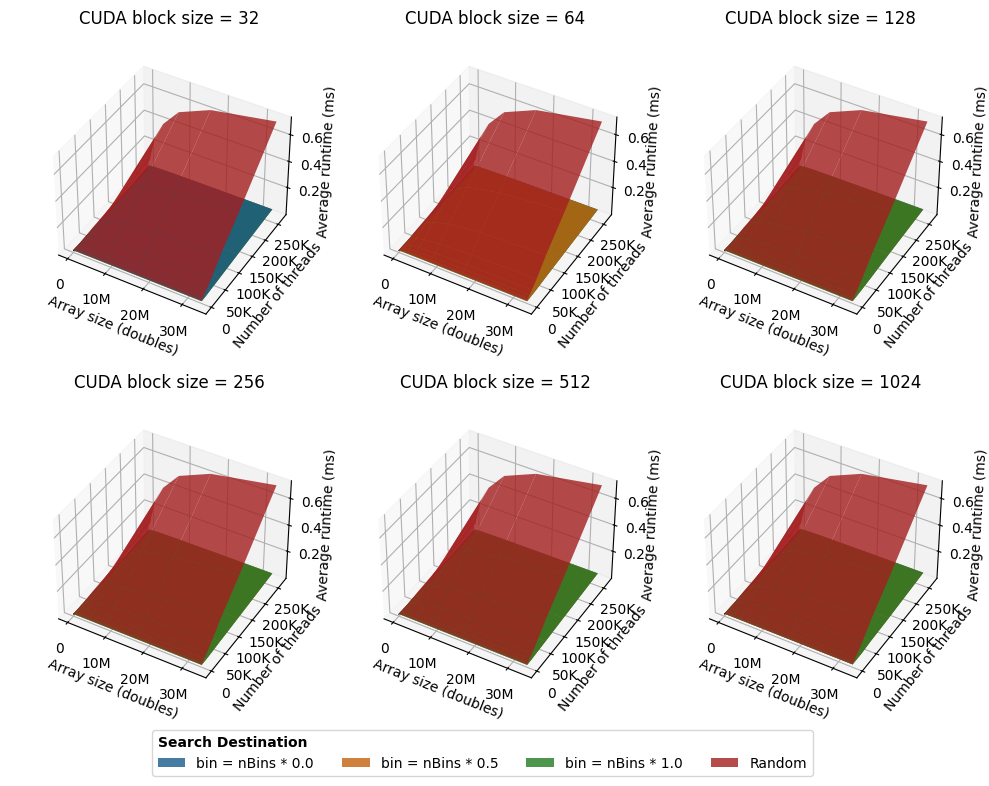

In [1604]:
# figname = "../../images/gpu_binsearch_mb_3d.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"}, figsize=(10, 10))
for bi, bs in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["blocksize"].unique()):
    ax = axs[int(bi/3), bi%3]
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        ax.set_title(f"CUDA block size = {bs}")
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == bs)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]
        X = avg["nbins"].unique()
        Y = avg["bulksize"].unique() # bulksize
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                         # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                        alpha=0.8,
                        label=f"bin = nBins * {int(dest)/4.}")


    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    X = avg["nbins"].unique()
    Y = avg["bulksize"].unique() # bulksize
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                 # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                    alpha=0.8,
                    label=f"Random",
                )

    ax.set_xlabel("Array size (doubles)")
    # ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel("Number of threads")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_zlabel(f"Average runtime ({unit})")
    # ax.set_yscale("log", base=2)
    # ax.set_zlim(3, 10)
    ax.zaxis.labelpad=-0.7 # <- change the value here
    ax.view_init(elev=40, azim=-60, roll=0)
    ax.set_box_aspect(aspect=None, zoom=0.83)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show

<function matplotlib.pyplot.show(block=None)>

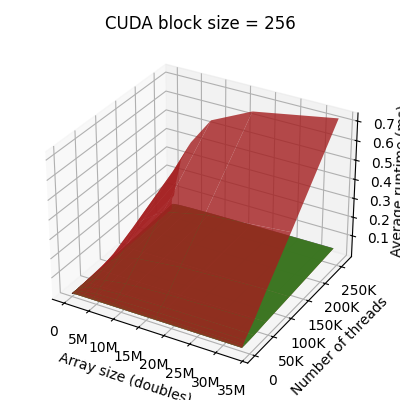

In [1643]:
%matplotlib widget
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"}, figsize=(4, 4))
bs = selected_blocksize
ax = axs
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    ax.set_title(f"CUDA block size = {bs}")
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["blocksize"] == bs)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    X = avg["nbins"].unique()
    Y = avg["bulksize"].unique() # bulksize
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                     # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                    alpha=0.8,
                    label=f"bin = nBins * {int(dest)/4.}")


arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
X = avg["nbins"].unique()
Y = avg["bulksize"].unique() # bulksize
Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
             # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                alpha=0.8,
                label=f"Random",
            )

ax.set_xlabel("Array size (doubles)")
# ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_ylabel("Number of threads")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_zlabel(f"Average runtime ({unit})")
# ax.set_yscale("log", base=2)
# ax.set_zlim(3, 10)
ax.zaxis.labelpad=-0.7 # <- change the value here

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
#            loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show

In [1644]:
%matplotlib inline

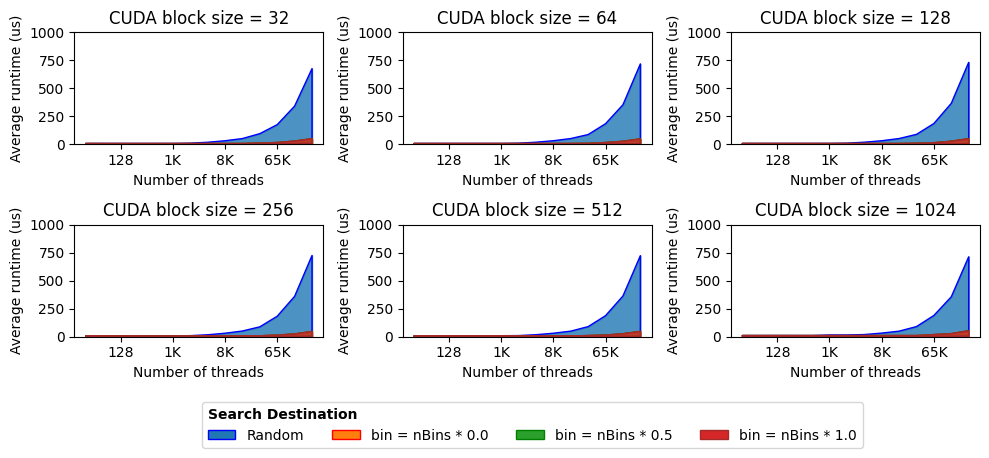

In [1646]:
figname = "../../images/gpu_binsearch_mb_variance.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for bi, bs in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["blocksize"].unique()):
    ax = axs[int(bi/3), bi%3]
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == bs))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    
    xname = "bulksize"
    X = sorted(avg[xname].unique())
    ymax = []; ymin = []
    norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    for bki, bks in enumerate(X):
        ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
        
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    fill_between_edges(ax, X, ymin, ymax, colors[0], ecolors[0], label=f"Random")
    
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        ax.set_title(f"CUDA block size = {bs}")
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == bs)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        X = sorted(avg[xname].unique())
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
            
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        fill_between_edges(ax, X, ymin, ymax, colors[di+1], ecolors[di+1], label=f"bin = nBins * {int(dest)/4.}")

    ax.set_xlabel(f'{"Array size (doubles)" if xname == "nbins" else "Number of threads"}')
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel(f"Average runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1000)




hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.2, -.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

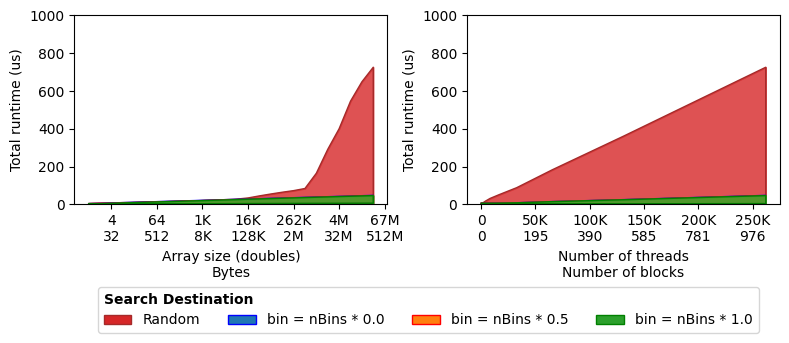

In [1647]:
figname = f"../../images/gpu_binsearch_mb_variance_{int(selected_blocksize)}blocksize.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for xi, xname in enumerate(["nbins" , "bulksize"]):
    ax = axs[xi]
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]

    X = avg[xname].unique()
    ymax = []; ymin = []
    norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    for bki, bks in enumerate(X):
        ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
        ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
        
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    fill_between_edges(ax, X, ymin, ymax, colors[3], ecolors[3], label=f"Random")
    
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
        arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == selected_blocksize)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]

        X = avg[xname].unique()
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
            
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        fill_between_edges(ax, X, ymin, ymax, colors[di], ecolors[di], label=f"bin = nBins * {int(dest)/4.}")

    if xname == "nbins":
        ax.set_xlabel("Array size (doubles)\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of blocks")
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
        # ax.plot(avg[xname].unique(), sorted(avg[xname].unique()))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1000)


hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

fig.tight_layout()
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.12, -.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

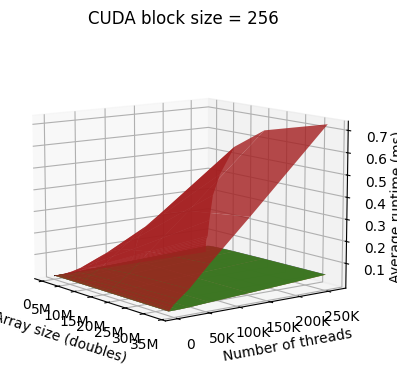

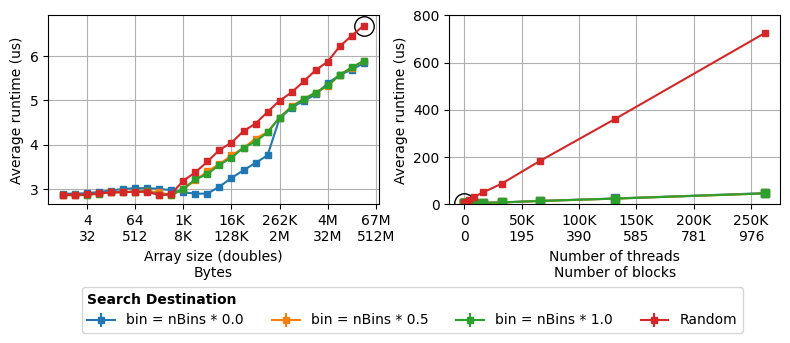

In [1645]:
## figname = "../../images/gpu_binsearch_mb.pdf"

selected_nbins = 33554432
# selected_nbins = 1
# selected_bulksize = 32768*8
selected_bulksize = 32
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] *norm, 
                  label=f"bin = nBins * {int(dest)/4.}", **bm_style)

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, label=f"Random",
             **bm_style
            )


plt.plot(selected_nbins, 
         avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 800])
plt.grid()

# plt.axvline(x=a4000_l2_size/8, c="k")
# plt.text(a4000_l2_size/8*1.2, 450, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_nbins)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm, 
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_nbins)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, **bm_style, 
             # label=f"v = {int(dest)/4.}"
            )

plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm ,
            'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([0, 800])

plt.grid()
plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

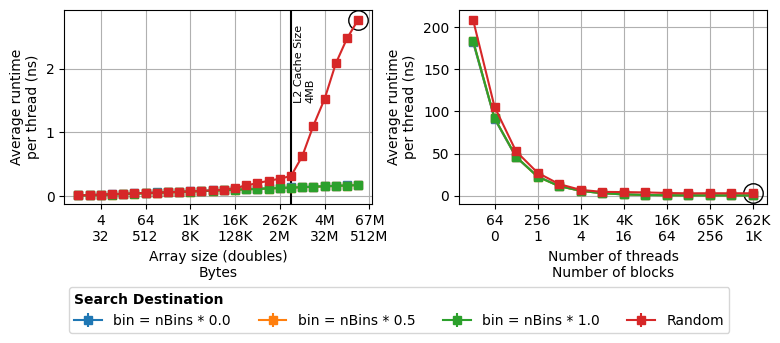

In [1610]:
average = True; figname = f"../../images/gpu_binsearch_mb{('_avg' if average else '')}.pdf"
selected_size = 33554432
selected_bulksize = 32768*8
selected_blocksize = 256
selected_val = 0
unit = "ns"
rep  = bsbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",label=f"bin = nBins * {int(dest)/4.}")

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             marker="s", label=f"Random"
            )

# selected point
plt.plot(selected_size, 
         avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"Average runtime\nper thread ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 800])
plt.grid()
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 1.5, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             # label=f"v = {int(dest)/4.}"
                 marker="s",
             
            )

# selected point
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
            **sl_style)
plt.xlabel("Number of threads\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

plt.ylabel(f"Average runtime\nper thread ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 800])
# ax.set_ylim([0, 0.02])
plt.grid()

plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

[1.56162451e-01 5.05375605e+03]


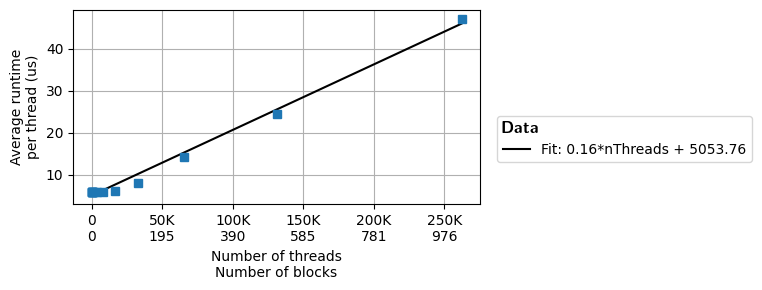

In [1611]:
# average = False; figname = f"../../images/gpu_addbincontent_calib{('_avg' if average else '')}.pdf"

###########
def T_bsearch(nthreads, a,b):
    # return a * np.exp(-b * nthreads) + c
    return a * nthreads + b
    
selected_nbins = 33554432
selected_bulksize = 32768*8
selected_blocksize = 256
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

#####
dest = '0'
arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
       & (bsbm_mean["param_3"] == dest) 
       & (bsbm_mean["nbins"] == selected_nbins)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
ax.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm, marker="s", ls="",
             # label=f"v = {int(dest)/4.}"
            )

norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], "ns") / rep 
T_bsearch_popt, pcov = scipy.optimize.curve_fit(T_bsearch,  avg["bulksize"], avg["real_time"]  * norm,                                      
                                                  # p0=[6784,24,0], 
                                                  # method='trf',
                                                  maxfev=100000)
x = np.linspace(0, max(avg["bulksize"]))
ax.plot(x, T_bsearch(x, *T_bsearch_popt) * unit_to_unit_factor("ns", unit), 'k-', 
         label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_bsearch_popt]))
print(T_bsearch_popt)

#####
# dest = ''
# arg = ((bsbm_mean["func_name"] == "BinarySearchGPURandom")
#        # & (bsbm_mean["param_3"] == dest) 
#        & (bsbm_mean["nbins"] == selected_nbins)  
#        & (bsbm_mean["blocksize"] == selected_blocksize))
# avg = bsbm_mean.loc[arg]
# std = bsbm_std.loc[arg]
# ax.errorbar(avg["bulksize"], avg["real_time"]  * norm,
#              yerr=std["real_time"] * norm, marker="s", ls="",
#              # label=f"v = {int(dest)/4.}"
#             )

# norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], "ns") / rep 
# T_bsearch_popt2, pcov = scipy.optimize.curve_fit(T_bsearch,  avg["bulksize"], avg["real_time"]  * norm,                                      
#                                                   # p0=[6784,24,0], 
#                                                   # method='trf',
#                                                   maxfev=100000)
# print(T_bsearch_popt2)
# plt.plot(x, T_bsearch(x, *T_bsearch_popt2) * unit_to_unit_factor("ns", unit), 'k-', 
#          label="Fit: {}*nThreads + {}".format(*[round(r, 2) for r in T_bsearch_popt2]))
# ####


plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 500])

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Data}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")

plt.grid()
fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

# plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [1612]:
def T_gpu_binsearch(distr, nbins):
    nbins = np.array(get_subsize(distr, nbins))
    r = np.repeat(700, len(nbins)).astype(np.float64) 
    r[nbins < a4000_l2_size/8] = 100
    r[nbins < 16e3] = 0.1
    return r

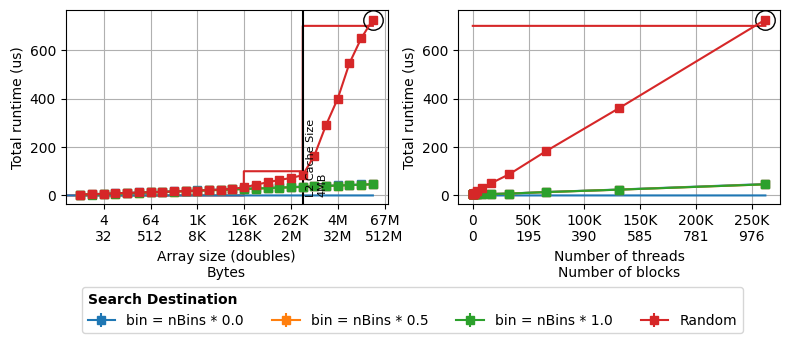

In [1613]:
average = False; figname = f"../../images/gpu_binsearch_calib{('_avg' if average else '')}.pdf"
selected_nbins = 33554432
selected_bulksize = 32768*8
# selected_bulksize = 1024
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = bsbm_mean["repetitions"].values[0]
    
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",label=f"bin = nBins * {int(dest)/4.}")

selected_func = "BinarySearchGPURandom"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             marker="s", label=f"Random"
            )

# Prediction
x = np.linspace(0, int(max(avg["nbins"])), 1000000)
plt.plot(x, T_gpu_binsearch("uniform", x), c=colors[3])
x = np.linspace(0, int(max(avg["nbins"])), 1000000)
plt.plot(x, T_gpu_binsearch("constant", x), c=colors[0])

# selected point
plt.plot(selected_size, 
         avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
         'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
plt.grid()

# Cache sizes
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 1.5, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',rotation=90, fontsize=8)

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchGPUConstant"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchGPUConstant")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
    plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
                 yerr=std["real_time"] * norm,
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
plt.errorbar(avg["bulksize"], avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             # label=f"v = {int(dest)/4.}"
                 marker="s",
             
            )

# Prediction
x = np.linspace(0, int(max(avg["bulksize"])), 10000)
plt.plot(x, np.repeat(T_gpu_binsearch("constant", [selected_nbins]), len(x)), c=colors[0])
plt.plot(x, np.repeat(T_gpu_binsearch("uniform", [selected_nbins]), len(x)), c=colors[3])

# selected point
norm = unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
plt.plot(selected_bulksize, 
            avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
            **sl_style)
plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
# secax = ax.secondary_xaxis('bottom')
# secax.set_xlabel('period [s]')

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
plt.grid()
# plt.yscale("symlog")
# plt.ylim([3.5, 8])
# ax.set_ylim([0, 0.02])

plt.tight_layout()
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Validation

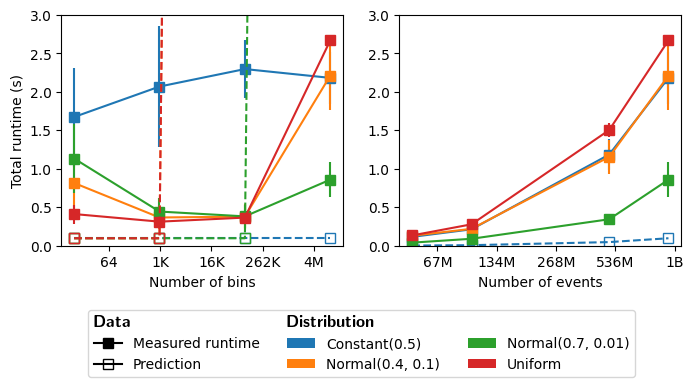

In [1614]:
figname="../../images/gpu_findbin_validation_das6.pdf"

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = True
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 3

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

# Legend Labels
ax.plot(0,0, label="Measured runtime", c="k", **vd_style)
ax.plot(0,0, label="Prediction", **pred_style)

for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nbins, avg["Total Time (ns)"]* norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                   )
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    # Prediction
    pred = T_gpu_binsearch(distr, vd_unique_nbins) * selected_nvals * norm
    ax.errorbar(vd_unique_nbins, pred, 
                c=p[0].get_color(),
                marker="s", markerfacecolor="none", ls="--", markersize=7,
                # label="Prediction"
    )
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

ax = plt.subplot(122)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, 
           selected_bulksize, selected_edges,  "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nvals, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )

    # Prediction
    pred = T_gpu_binsearch(distr, [selected_nbins]) * vd_unique_nvals * norm
    ax.errorbar(vd_unique_nvals, pred, 
                c=p[0].get_color(),
                marker="s", markerfacecolor="none", ls="--", markersize=7,
                # label="Prediction"
    )
    
    plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylim([0, hmax])


ax = plt.subplot(121)
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.35), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Add Bin Content

## Design

In [1615]:
filename = "../microbenchmarks/das6/addbincontent_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
abcbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(abcbm_df, "real_time", np.float64)
abcbm_df["func_name"] = abcbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
abcbm_df["time_factor"] = abcbm_df["time_unit"].apply(convert_unit)
del (
    abcbm_df["family_index"], abcbm_df["per_family_instance_index"],  
    abcbm_df["run_name"], abcbm_df["threads"], abcbm_df["run_type"], 
    abcbm_df["aggregate_unit"], abcbm_df["repetition_index"],  abcbm_df["error_occurred"],
    abcbm_df["error_message"]
)
abcbm_df["time_factor"] = abcbm_df["time_unit"].apply(convert_unit)
abcbm_df

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,global,nbins,numblocks,random,func_name,time_factor
0,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,1000.0,mean,3,4052.629471,4049.260000,us,32.0,32.0,1.0,1.0,1.0,1.0,HistogramGPU,1000000.0
1,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,1000.0,median,3,4056.000233,4052.240000,us,32.0,32.0,1.0,1.0,1.0,1.0,HistogramGPU,1000000.0
2,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,0.0,stddev,3,45.150571,49.529282,us,0.0,0.0,0.0,0.0,0.0,0.0,HistogramGPU,1000000.0
3,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,0.0,cv,3,0.011141,0.012232,us,0.0,0.0,0.0,0.0,0.0,0.0,HistogramGPU,1000000.0
4,BM_HistogramGPU/16/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,4058.111827,4049.076667,us,32.0,32.0,1.0,2.0,1.0,1.0,HistogramGPU,1000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,BM_HistogramGPU/134217728/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000000.0
18716,BM_HistogramGPU/134217728/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000000.0
18717,BM_HistogramGPU/268435456/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000000.0
18718,BM_HistogramGPU/268435456/262144/1024/0/0/min_...,3.0,NaN,0,0.000000,0.000000,us,NaN,NaN,NaN,NaN,NaN,NaN,HistogramGPU,1000000.0


In [1616]:
unique_bulksize = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["bulksize"].unique_non_nan()
unique_blocksize = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["blocksize"].unique_non_nan()
unique_numblocks = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["numblocks"].unique_non_nan()
unique_nbins = abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"]["nbins"].unique_non_nan()
unique_global = [True, False]
unique_random = [True, False]
unique_nbins, unique_bulksize, unique_blocksize, unique_numblocks, unique_global, unique_random

(array([1.0000000e+00, 2.0000000e+00, 4.0000000e+00, 8.0000000e+00,
        1.6000000e+01, 3.2000000e+01, 6.4000000e+01, 1.2800000e+02,
        2.5600000e+02, 5.1200000e+02, 1.0240000e+03, 2.0480000e+03,
        4.0960000e+03, 8.1920000e+03, 1.6384000e+04, 3.2768000e+04,
        6.5536000e+04, 1.3107200e+05, 2.6214400e+05, 5.2428800e+05,
        1.0485760e+06, 2.0971520e+06, 4.1943040e+06, 8.3886080e+06,
        1.6777216e+07, 3.3554432e+07]),
 array([3.20000e+01, 6.40000e+01, 2.56000e+02, 1.02400e+03, 4.09600e+03,
        1.63840e+04, 6.55360e+04, 2.62144e+05]),
 array([  32.,   64.,  128.,  256.,  512., 1024.]),
 array([1.000e+00, 2.000e+00, 8.000e+00, 3.200e+01, 1.280e+02, 5.120e+02,
        2.048e+03, 8.192e+03, 4.000e+00, 1.600e+01, 6.400e+01, 2.560e+02,
        1.024e+03, 4.096e+03]),
 [True, False],
 [True, False])

In [1617]:
# n_param = len(abcbm_df["name"].values[0].split("/")) - 1
# for i in range(n_param):
#     if i == n_param - 1:
#         abcbm_df[f"param_{i}"] = abcbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
#     else:
#         abcbm_df[f"param_{i}"] = abcbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(abcbm_df, "bulksize", np.int64)
convert_to_type(abcbm_df, "blocksize", np.int64)
convert_to_type(abcbm_df, "numblocks", np.int64)
convert_to_type(abcbm_df, "nbins", np.int64)
convert_to_type(abcbm_df, "random", np.bool_)
convert_to_type(abcbm_df, "global", np.bool_)
abcbm_mean = (abcbm_df.loc[abcbm_df["aggregate_name"] == "mean"].reset_index())
abcbm_std = (abcbm_df.loc[abcbm_df["aggregate_name"] == "stddev"].reset_index())
abcbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,global,nbins,numblocks,random,func_name,time_factor
0,0,BM_HistogramGPU/8/32/32/1/1/min_time:0.000/man...,1000.0,mean,3,4.052629e+03,4.049260e+03,us,32.0,32.0,True,1.0,1.0,True,HistogramGPU,1000000.0
1,4,BM_HistogramGPU/16/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,4.058112e+03,4.049077e+03,us,32.0,32.0,True,2.0,1.0,True,HistogramGPU,1000000.0
2,8,BM_HistogramGPU/32/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,3.996331e+03,3.991499e+03,us,32.0,32.0,True,4.0,1.0,True,HistogramGPU,1000000.0
3,12,BM_HistogramGPU/64/32/32/1/1/min_time:0.000/ma...,1000.0,mean,3,3.993259e+03,3.989512e+03,us,32.0,32.0,True,8.0,1.0,True,HistogramGPU,1000000.0
4,16,BM_HistogramGPU/128/32/32/1/1/min_time:0.000/m...,1000.0,mean,3,3.990144e+03,3.986826e+03,us,32.0,32.0,True,16.0,1.0,True,HistogramGPU,1000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,18661,BM_HistogramGPU/2048/262144/1024/0/0/min_time:...,1000.0,mean,3,1.169041e+06,1.168033e+06,us,1024.0,262144.0,False,256.0,256.0,False,HistogramGPU,1000000.0
3740,18665,BM_HistogramGPU/4096/262144/1024/0/0/min_time:...,1000.0,mean,3,1.165787e+06,1.164805e+06,us,1024.0,262144.0,False,512.0,256.0,False,HistogramGPU,1000000.0
3741,18669,BM_HistogramGPU/8192/262144/1024/0/0/min_time:...,1000.0,mean,3,1.169202e+06,1.168178e+06,us,1024.0,262144.0,False,1024.0,256.0,False,HistogramGPU,1000000.0
3742,18673,BM_HistogramGPU/16384/262144/1024/0/0/min_time...,1000.0,mean,3,1.171571e+06,1.170564e+06,us,1024.0,262144.0,False,2048.0,256.0,False,HistogramGPU,1000000.0


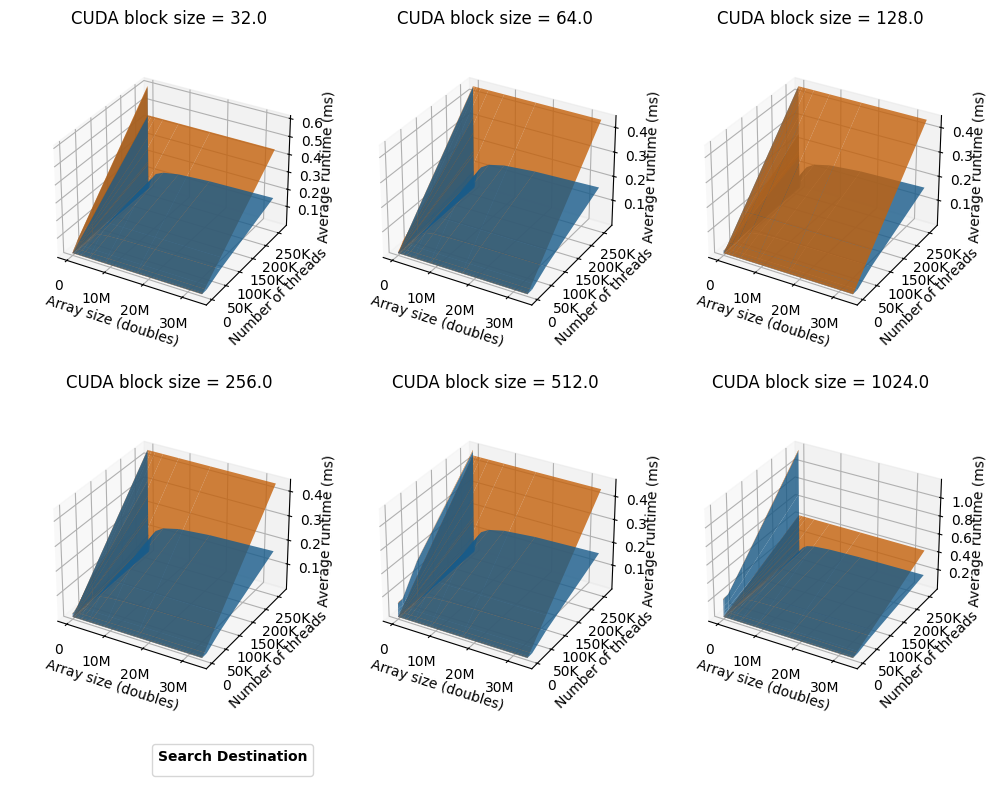

In [1618]:
figname = "../../images/gpu_addbincontent_mb_3d.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"}, figsize=(10, 10))
for bi, bs in enumerate(unique_blocksize):
    ax = axs[int(bi/3), bi%3]
    # ax.grid()
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            ax.set_title(f"CUDA block size = {bs}")
            arg = ((abcbm_mean["random"] == rndmdest) 
                   & (abcbm_mean["blocksize"] == bs)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            X = avg["nbins"].unique()
            Y = avg["bulksize"].unique() # bulksize
            Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                             # yerr=std["real_time"] * unit_to_unit_factor(abcbm_std["time_unit"].values[0], unit) / rep, 
                            alpha=0.8,
                            color=colors[0] if rndmdest else colors[1], 
                            # hatch="xx" if htglbl else "",
                            rstride=1, cstride=1,
                            label=f"")
    

    ax.set_xlabel("Array size (doubles)")
    # ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel("Number of threads")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_zlabel(f"Average runtime ({unit})")
    # ax.set_yscale("log", base=2)
    # ax.set_zlim(3, 10)
    ax.zaxis.labelpad=-0.7 # <- change the value here
    # ax.view_init(elev=30, azim=60, roll=0)
    ax.set_box_aspect(aspect=None, zoom=0.83)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()

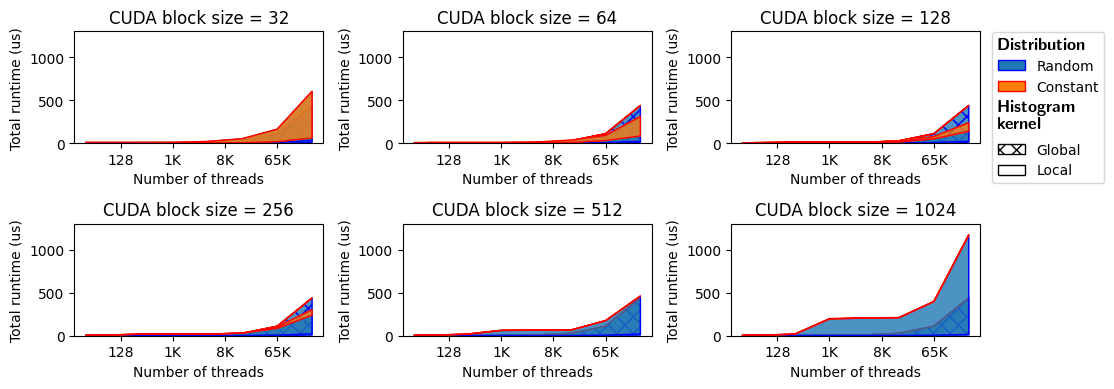

In [1619]:
figname = "../../images/gpu_addbincontent_mb_variance.pdf"
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 33554432
# selected_random = True
# selected_global = False
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))
for bi, bs in enumerate(unique_blocksize):
    ax = axs[int(bi/3), bi%3]
    # ax.grid()
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            ax.set_title(f"CUDA block size = {int(bs)}")
            arg = ((abcbm_mean["blocksize"] == bs)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
    
            xname = "bulksize"
            X = sorted(avg[xname].unique())
            ymax = []; ymin = []
            norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            for bki, bks in enumerate(X):
                ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
                ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)
                
            Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            fill_between_edges(ax, X, ymin, ymax, 
                               facecolor=colors[0] if rndmdest else colors[1], 
                               edgecolor="b" if rndmdest else "r", 
                                label="",
                                hatch="xx" if htglbl else "", 
                              )
            
    ax.set_xlabel(f'{"Array size (doubles)" if xname == "nbins" else "Number of threads"}')
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 1300)
    
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,  hatch="xx" , edgecolor="k", facecolor="white", label=f"Global"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor="white", edgecolor="k", label=f"Local"))

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.51), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

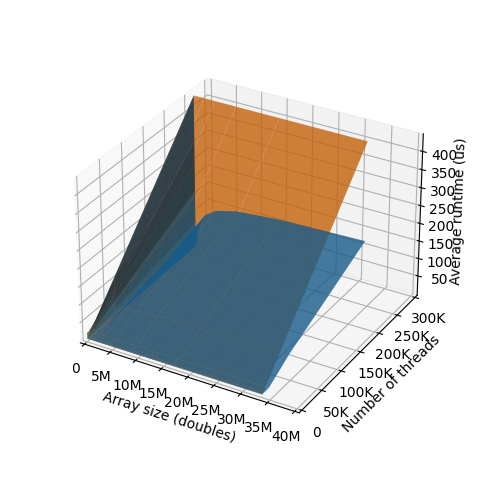

In [1620]:
# %matplotlib widget
figname = "../../images/gpu_addbincontent_mb_3d_256blocksize.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"}, figsize=(5, 5))
# for ai, angle in enumerate(range(0)):
    # ax = axs[int(ai/3), ai%3]
ax = axs
# ax.grid()
for hti, htglbl in enumerate([True, False]):
    for di, rndmdest in enumerate([True, False]):
        # ax.set_title(f"CUDA block size = {bs}")
        arg = ((abcbm_mean["random"] == rndmdest) 
               & (abcbm_mean["blocksize"] == selected_blocksize)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]
        X = avg["nbins"].unique()
        Y = avg["bulksize"].unique() # bulksize
        Z = avg["real_time"] * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
        ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                         # yerr=std["real_time"] * unit_to_unit_factor(abcbm_std["time_unit"].values[0], unit) / rep, 
                        alpha=0.8,
                        color=colors[hti*2+di],
                        # if rndmdest else colors[1], 
                        # hatch="xx" if htglbl else "",
                        rstride=1, cstride=1,
                        label=f"")


ax.set_xlabel("Array size (doubles)")
# ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_ylabel("Number of threads")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
ax.set_zlabel(f"Average runtime ({unit})")
# ax.set_yscale("log", base=2)
ax.zaxis.labelpad=-0.7 # <- change the value here
# ax.view_init(elev=10, azim=angle, roll=0)
ax.set_box_aspect(aspect=None, zoom=0.83)
ax.set_xlim(0, 40000000)
ax.set_ylim(0, 300000)
# ax.invert_xaxis()

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
#            loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show()


In [1621]:
%matplotlib inline

In [1622]:
avg.loc[avg[xname] == bks]["real_time"].max() / rep * unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit)

302.9418640136718

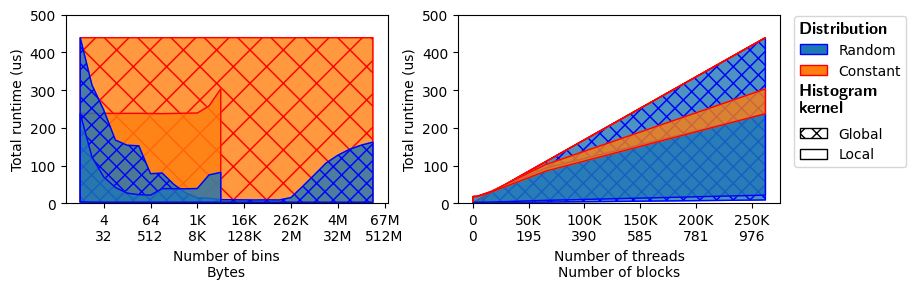

In [1623]:
figname = "../../images/gpu_addbincontent_mb_variance_256blocksize.pdf"
selected_nbins = 4096
selected_bulksize = 262144
selected_blocksize = 256
# selected_random = True
# selected_global = False
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for xi, xname in enumerate(["nbins"]):
    ax = axs[xi]
    # ax.grid()
    for di, rndmdest in enumerate([False, True]):
        for hti, htglbl in enumerate([True, False]):
            # ax.set_title(f"Array size (doubles) = {int(selected_nbins)}")
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
    
            X = sorted(avg[xname].unique())
            ymax = []; ymin = []
            norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
            for bki, bks in enumerate(X):
                ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
                ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)

            hatch = ""
            if htglbl:
                if rndmdest: hatch="xx"
                else: hatch="x"
            Z = avg["real_time"] * norm
            fill_between_edges(ax, X, ymin, ymax, 
                               facecolor=colors[0] if rndmdest else colors[1], 
                               edgecolor="b" if rndmdest else "r", 
                               label="",
                               hatch=hatch,
                               # edgelinewidth=2
                                # hatch="xx" if htglbl else "", 
                              )
    if xname == "nbins":
        ax.set_xlabel(f"Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of blocks")
        # ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 500)
######
for xi, xname in enumerate(["bulksize"]):
    ax = axs[1]
    for rndmdest, htglbl in ([[True, True], [False, True], [True, False], [False, False]]):
        # for hti, htglbl in enumerate([True, False]):
        # ax.set_title(f"Array size (doubles) = {int(selected_nbins)}")
        arg = ((abcbm_mean["blocksize"] == selected_blocksize)
               # & (abcbm_mean["bulksize"] == selected_bulksize) 
               # & (abcbm_mean["nbins"] == selected_nbins)
               & (abcbm_mean["random"] == rndmdest)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]

        X = sorted(avg[xname].unique())
        ymax = []; ymin = []
        norm =  unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep
        for bki, bks in enumerate(X):
            ymin.append(avg.loc[avg[xname] == bks]["real_time"].min() * norm)
            ymax.append(avg.loc[avg[xname] == bks]["real_time"].max() * norm)

        hatch = ""
        if htglbl:
            if rndmdest: hatch="xx"
            else: hatch="x"
        Z = avg["real_time"] * norm
        fill_between_edges(ax, X, ymin, ymax, 
                           facecolor=colors[0] if rndmdest else colors[1], 
                           edgecolor="b" if rndmdest else "r", 
                           label="",
                           hatch=hatch,
                           # edgelinewidth=2
                            # hatch="xx" if htglbl else "", 
                          )
    if xname == "nbins":
        ax.set_xlabel(f"Number of bins\nBytes")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
    else:
        ax.set_xlabel("Number of threads\nNumber of blocks")
        # ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))
    ax.set_ylabel(f"Total runtime ({unit})")
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    # ax.set_yscale("log", base=2)
    ax.set_ylim(0, 500)
###
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], edgecolor=ecolors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], edgecolor=ecolors[1], label=f"Constant"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,  hatch="xx" , edgecolor="k", facecolor="white", label=f"Global"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor="white", edgecolor="k", label=f"Local"))

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.4), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
# fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show();

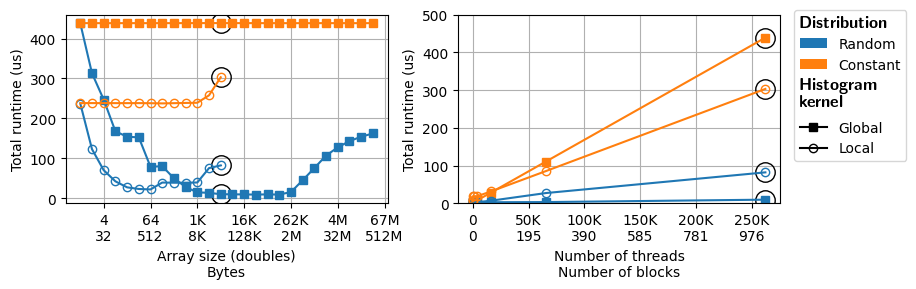

In [1624]:
average = False; figname = f"../../images/gpu_addbincontent_mb{('_avg' if average else '')}.pdf"

# selected_nbins = unique_nbins[-
selected_nbins = 4096
selected_bulksize = 262144
# selected_bulksize = 
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for hti, htglbl in enumerate([True, False]):
    for di, rndmdest in enumerate([True, False]):
        arg = ((abcbm_mean["blocksize"] == selected_blocksize)
               & (abcbm_mean["bulksize"] == selected_bulksize) 
               # & (abcbm_mean["nbins"] == selected_nbins)
               & (abcbm_mean["random"] == rndmdest)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]
        c = colors[0] if rndmdest else colors[1]
        ax.errorbar(avg["nbins"], 
                     avg["real_time"]  * norm,
                     yerr=std["real_time"] *norm, 
                     color=c,
                     marker="s" if htglbl else "o",
                     markerfacecolor=c if htglbl else "none"
                     # label=f"{'Global' if dest else 'Local'}", 
                     # **bm_style
                    )
        if len(avg.loc[avg["nbins"] == selected_nbins].values) > 0:
            plt.plot(selected_nbins, 
                     avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
                     'ok', ms=14, markerfacecolor="None",)

# plt.axvline(x=a4000_maxsmem/8, c="k")
# plt.text(a4000_maxsmem/8*1.2, 5*norm, f'Shared memory\n{human_readable(a4000_maxsmem, bytes=True)}B',
#          rotation=90, fontsize=8)
# plt.axvline(x=a4000_l2_size/8, c="k")
# plt.text(a4000_l2_size/8*1.2, 5*norm, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',
#          rotation=90, fontsize=8)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([0, 500])
plt.grid()

#############

ax = plt.subplot(122)
for hti, htglbl in enumerate([True, False]):
    for di, rndmdest in enumerate([True, False]):
        arg = ((abcbm_mean["blocksize"] == selected_blocksize)
               # & (abcbm_mean["bulksize"] == selected_bulksize) 
               & (abcbm_mean["nbins"] == selected_nbins)
               & (abcbm_mean["random"] == rndmdest)
               & (abcbm_mean["global"] == htglbl)
              )
        avg = abcbm_mean.loc[arg]
        std = abcbm_std.loc[arg]
        
        if len(avg.values)>0:
            norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["bulksize"], 
                         avg["real_time"]  * norm,
                         yerr=std["real_time"] *norm,
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )
            
            norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
            plt.plot(selected_bulksize, 
                     avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
                     'ok', ms=14, markerfacecolor="None",)
            
# plt.plot(selected_size, 
#          avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
#          'ok', ms=14, markerfacecolor="None",)
plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([0, 500])

ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
ax.plot(0, 0, color="k", marker="s", label=f"Global")
ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

plt.grid()
fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

[1.66528941e-03 1.94094704e+00]
[8.71109531e-01 1.52247128e+04]


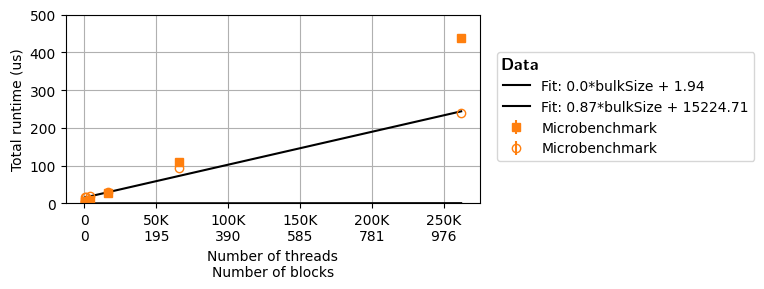

In [1625]:
average = False; figname = f"../../images/gpu_addbincontent_calib{('_avg' if average else '')}.pdf"

###########
def T_atomic(nthreads, a,b):
    # return a * np.exp(-b * nthreads) + c
    return a * nthreads + b
    
selected_nbins = 1
selected_bulksize = 262144
selected_blocksize = 256
selected_val = 0
unit = "us"
rep  = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

#####
htglbl = True
rndmdest = False
arg = ((abcbm_mean["blocksize"] == selected_blocksize)
       & (abcbm_mean["nbins"] == selected_nbins)
       & (abcbm_mean["random"] == rndmdest)
       & (abcbm_mean["global"] == htglbl))
avg = abcbm_mean.loc[arg]
std = abcbm_std.loc[arg]

x = np.linspace(0, max(avg["bulksize"]))
norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
ax.errorbar(avg["bulksize"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] *norm,
             color=colors[1], ls="",
             marker="s" if htglbl else "o",
             markerfacecolor=colors[1] if htglbl else "none",
             label=f"Microbenchmark", 
             # **bm_style
        )

c
T_globatomic_popt, pcov = scipy.optimize.curve_fit(T_atomic,  avg["bulksize"], avg["real_time"]  * norm,
                                      # p0=[6784,24,0], 
                                      # method='trf',
                                      maxfev=100000)
print(T_globatomic_popt)
plt.plot(x, T_atomic(x, *T_globatomic_popt) * unit_to_unit_factor("ns", unit), 'k-', 
         label="Fit: {}*bulkSize + {}".format(*[round(r, 2) for r in T_globatomic_popt]))

#####
htglbl = False
rndmdest = False
arg = ((abcbm_mean["blocksize"] == selected_blocksize)
       & (abcbm_mean["nbins"] == selected_nbins)
       & (abcbm_mean["random"] == rndmdest)
       & (abcbm_mean["global"] == htglbl))
avg = abcbm_mean.loc[arg]
std = abcbm_std.loc[arg]
norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
ax.errorbar(avg["bulksize"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] *norm,
             color=colors[1], ls="",
             marker="s" if htglbl else "o",
             markerfacecolor=colors[1] if htglbl else "none",
             label=f"Microbenchmark", 
             # **bm_style
        )

norm = (unit_to_unit_factor(abcbm_mean["time_unit"].values[0], "ns") / rep / 
        (avg["bulksize"].loc[avg["bulksize"] > 4096] if average else 1))
T_lclatomic_popt, pcov = scipy.optimize.curve_fit(T_atomic,  avg["bulksize"], avg["real_time"]  * norm,
                                      # p0=[6784,24,0], 
                                      # method='trf',
                                      maxfev=100000)
print(T_lclatomic_popt)
plt.plot(x, T_atomic(x, *T_lclatomic_popt) * unit_to_unit_factor("ns", unit), 'k-', 
         label="Fit: {}*bulkSize + {}".format(*[round(r, 2) for r in T_lclatomic_popt]))

#######

plt.xlabel("Number of threads\nNumber of blocks")
# plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([0, 500])

# ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
# ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
# ax.plot(0, 0, color="k", marker="s", label=f"Global")
# ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Data}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")

plt.grid()
fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [1626]:
T_atomic

<function __main__.T_atomic(nthreads, a, b)>

In [1627]:
def T_gpu_addbincontent(global_kernel, nvals, bulksize, distr, nbins):
    global_kernel = np.array(global_kernel)
    lcl_kernel = np.invert( global_kernel)
    subsize = np.array(get_subsize(distr, nbins))
    
    try:
        T = np.zeros(len(global_kernel))
        T[global_kernel] = T_atomic(bulksize/subsize[global_kernel], *T_globatomic_popt)
        T[lcl_kernel] = T_atomic(bulksize/subsize[lcl_kernel], *T_lclatomic_popt)
    except:
        if global_kernel:
            T = T_atomic(bulksize/subsize, *T_globatomic_popt)
            
        else:
            T = T_atomic(bulksize/subsize, *T_lclatomic_popt)
            
    return T
# T_gpu_addbincontent = np.vectorize(T_gpu_addbincontent)

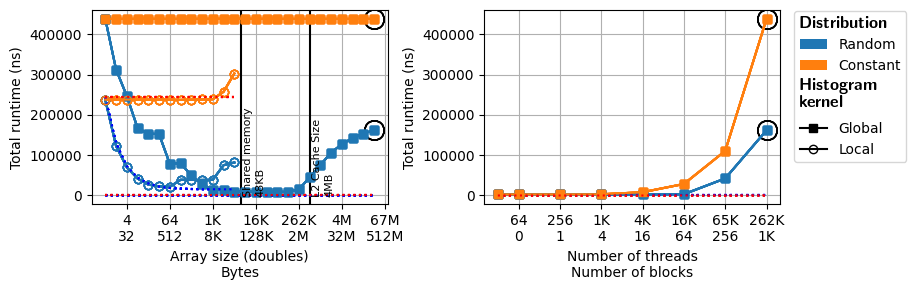

In [1628]:
average = False; figname = f"../../images/gpu_addbincontent_calib{('_avg' if average else '')}.pdf"

selected_nbins = unique_nbins[-1]
selected_bulksize = 262144
selected_blocksize = 256
unit = "ns"
rep  = abcbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate(unique_global):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   & (abcbm_mean["bulksize"] == selected_bulksize) 
                   # & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            c = colors[0] if rndmdest else colors[1]
            ax.errorbar(avg["nbins"], 
                         avg["real_time"]  * norm,
                         yerr=std["real_time"] *norm, 
                         color=c,
                         marker="s" if htglbl else "o",
                         markerfacecolor=c if htglbl else "none"
                         # label=f"{'Global' if dest else 'Local'}", 
                         # **bm_style
                        )

            if len(avg.loc[avg["nbins"] == selected_nbins].values) > 0:
                ax.plot(selected_nbins, 
                         avg.loc[avg["nbins"] == selected_nbins]["real_time"] * norm,
                         'ok', ms=14, markerfacecolor="None",)

            # Prediction
            c = "b" if rndmdest else "r"
            pred = T_gpu_addbincontent(htglbl, selected_bulksize, selected_bulksize, 
                                         "uniform" if rndmdest else "constant", avg["nbins"],
                                        ) * unit_to_unit_factor("ns", unit)
            ax.errorbar(avg["nbins"], pred,
                     color=c, ls=":",
                     # marker="s" if htglbl else "o", 
                     # markerfacecolor=c if htglbl else "none",
                    )

plt.axvline(x=a4000_maxsmem/8, c="k")
plt.text(a4000_maxsmem/8*1.2, 5*norm, f'Shared memory\n{human_readable(a4000_maxsmem, bytes=True)}B',
         rotation=90, fontsize=8)
plt.axvline(x=a4000_l2_size/8, c="k")
plt.text(a4000_l2_size/8*1.2, 5*norm, f'L2 Cache Size\n{human_readable(a4000_l2_size, bytes=True)}B',
         rotation=90, fontsize=8)

plt.xlabel("Array size (doubles)\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.yscale("log", base=2)
# plt.ylim([3.5, 8])
plt.grid()

#############

average = False
ax = plt.subplot(122)
for bi, bs in enumerate(unique_blocksize):
    for hti, htglbl in enumerate([True, False]):
        for di, rndmdest in enumerate([True, False]):
            arg = ((abcbm_mean["blocksize"] == selected_blocksize)
                   # & (abcbm_mean["bulksize"] == selected_bulksize) 
                   & (abcbm_mean["nbins"] == selected_nbins)
                   & (abcbm_mean["random"] == rndmdest)
                   & (abcbm_mean["global"] == htglbl)
                  )
            avg = abcbm_mean.loc[arg]
            std = abcbm_std.loc[arg]
            
            if len(avg.values)>0:
                norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
                c = colors[0] if rndmdest else colors[1]
                ax.errorbar(avg["bulksize"], 
                             avg["real_time"]  * norm,
                             yerr=std["real_time"] *norm,
                             color=c,
                             marker="s" if htglbl else "o",
                             markerfacecolor=c if htglbl else "none"
                             # label=f"{'Global' if dest else 'Local'}", 
                             # **bm_style
                            )
                
                # Selected points
                norm = unit_to_unit_factor(abcbm_mean["time_unit"].values[0], unit) / rep / (selected_bulksize if average else 1)
                plt.plot(selected_bulksize, 
                         avg.loc[avg["bulksize"] == selected_bulksize]["real_time"] * norm,
                         'ok', ms=14, markerfacecolor="None",)
    
                # Prediction
                c = "b" if rndmdest else "r"
                pred = T_gpu_addbincontent(htglbl, avg["bulksize"], avg["bulksize"],
                                             "uniform" if rndmdest else "constant", selected_nbins,
                                            )  * unit_to_unit_factor("ns", unit)
                ax.errorbar(avg["bulksize"], pred,
                         color=c, 
                         # ms=13, marker="s" if htglbl else "o", 
                         # markerfacecolor=c if htglbl else "none",
                         # markerfacecolor="k",
                         ls=":",
                        )
            
# plt.plot(x, T_atomic * unit_to_unit_factor("ns", unit), 'k-', label="Fitted Curve")

plt.xlabel("Number of threads\nNumber of blocks")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{human_readable(int(x))}\n{human_readable(x/selected_blocksize)}"))

if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

# plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[0], label=f"Random"))
ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[1], label=f"Constant"))
ax.plot(0, 0, color="k", marker="s", label=f"Global")
ax.plot(0, 0, color="k", marker="o", markerfacecolor="none", label=f"Local")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, r"\textbf{Distribution}")
hndls.insert(3, "")
hndls.insert(3, r"\noindent\textbf{Histogram}\\\textbf{kernel}")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(3, "")

plt.grid()
fig.legend(hndls, lbls, title="",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(0.99, 0.42), ncols=1,                     
           handler_map={str: LightLegendTitle({'fontsize':12})}
          )
fig.tight_layout()

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Validation

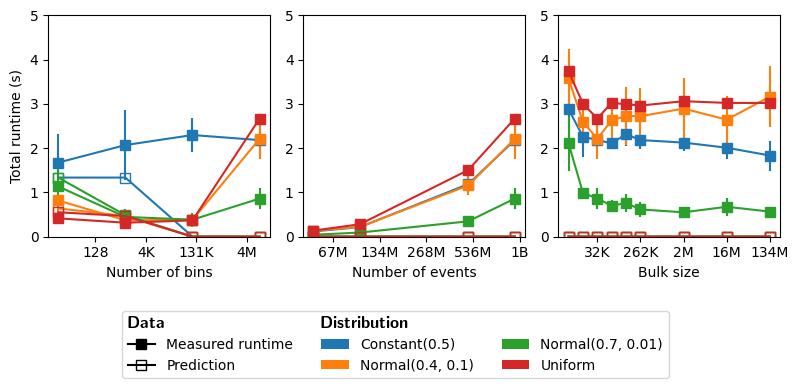

In [1629]:
figname="../../images/gpu_addbincontent_validation_das6.pdf"

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = True
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 5

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(131)

# Legend Labels
ax.plot(0,0, label="Measured runtime", c="k", **vd_style)
ax.plot(0,0, label="Prediction", **pred_style)

for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nbins, avg["Total Time (ns)"]* norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                   )
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    # prediction
    pred = T_gpu_addbincontent(vd_unique_nbins*8 > a4000_maxsmem, selected_nvals, selected_bulksize,
                               distr, vd_unique_nbins)  * norm * (selected_nvals/selected_bulksize)
    ax.errorbar(vd_unique_nbins, pred, 
                c=p[0].get_color(),  **pred_nocolor_style
               )
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

##########

ax = plt.subplot(132)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, 
           selected_bulksize, selected_edges,  "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nvals, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )
    
    # prediction
    pred = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, vd_unique_nvals, selected_bulksize,
                               distr, selected_nbins)  * norm * (vd_unique_nvals/selected_bulksize)
    ax.errorbar(vd_unique_nvals, pred, 
                c=p[0].get_color(),  **pred_nocolor_style
               )
    
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)
    
    plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylim([0, hmax])

# #####################
ax = plt.subplot(133)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
           vd_unique_bulksize, selected_edges,  "FindBin + AddBinContent")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_bulksize, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    # label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )
    
    # prediction
    pred = T_gpu_addbincontent(selected_nbins*8 > a4000_maxsmem, selected_nvals, vd_unique_bulksize,
                               distr, selected_nbins)  * norm  * (selected_nvals/vd_unique_bulksize)
    ax.errorbar(vd_unique_bulksize, pred, 
                c=p[0].get_color(),  **pred_nocolor_style
               )

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
# #############

ax = plt.subplot(131)
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
fig.tight_layout()
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.3), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Update Stats

## Design

In [1630]:
filename = "../microbenchmarks/das6/transformreduce_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
trbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(trbm_df, "real_time", np.float64)
trbm_df["func_name"] = trbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
trbm_df["time_factor"] = trbm_df["time_unit"].apply(convert_unit)
del trbm_df["family_index"], trbm_df["per_family_instance_index"],  trbm_df["run_name"], trbm_df["threads"], trbm_df["run_type"], trbm_df["aggregate_unit"]
trbm_df["time_factor"] = trbm_df["time_unit"].apply(convert_unit)

trbm_df.head(10)

,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,numblocks,numthreads,func_name,time_factor
0,BM_TransformReduceGPU/32/32/min_time:0.001/man...,10000.0,mean,3,42383.369446,42308.476333,us,32.0,32.0,1.0,16.0,TransformReduceGPU,1000000.0
1,BM_TransformReduceGPU/32/32/min_time:0.001/man...,10000.0,median,3,42513.439178,42443.949000,us,32.0,32.0,1.0,16.0,TransformReduceGPU,1000000.0
2,BM_TransformReduceGPU/32/32/min_time:0.001/man...,0.0,stddev,3,378.127925,369.132812,us,0.0,0.0,0.0,0.0,TransformReduceGPU,1000000.0
3,BM_TransformReduceGPU/32/32/min_time:0.001/man...,0.0,cv,3,0.008922,0.008725,us,0.0,0.0,0.0,0.0,TransformReduceGPU,1000000.0
4,BM_TransformReduceGPU/64/32/min_time:0.001/man...,10000.0,mean,3,41593.503316,41525.785333,us,32.0,64.0,1.0,32.0,TransformReduceGPU,1000000.0
5,BM_TransformReduceGPU/64/32/min_time:0.001/man...,10000.0,median,3,41706.497192,41637.244000,us,32.0,64.0,1.0,32.0,TransformReduceGPU,1000000.0
6,BM_TransformReduceGPU/64/32/min_time:0.001/man...,0.0,stddev,3,355.231878,354.231052,us,0.0,0.0,0.0,0.0,TransformReduceGPU,1000000.0
7,BM_TransformReduceGPU/64/32/min_time:0.001/man...,0.0,cv,3,0.008541,0.008530,us,0.0,0.0,0.0,0.0,TransformReduceGPU,1000000.0
8,BM_TransformReduceGPU/128/32/min_time:0.001/ma...,10000.0,mean,3,41960.436503,41894.822333,us,32.0,128.0,2.0,32.0,TransformReduceGPU,1000000.0
9,BM_TransformReduceGPU/128/32/min_time:0.001/ma...,10000.0,median,3,42005.504608,41937.559000,us,32.0,128.0,2.0,32.0,TransformReduceGPU,1000000.0


In [1631]:
n_param = len(trbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        trbm_df[f"param_{i}"] = trbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        trbm_df[f"param_{i}"] = trbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(trbm_df, "numthreads", np.int64)
convert_to_type(trbm_df, "numblocks", np.int64)
convert_to_type(trbm_df, "blocksize", np.int64)

trbm_mean = trbm_df.loc[trbm_df["aggregate_name"] == "mean"].reset_index()
trbm_std = trbm_df.loc[trbm_df["aggregate_name"] == "stddev"].reset_index()
# convert_to_type(
trbm_mean

,index,name,repetitions,aggregate_name,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,numblocks,numthreads,func_name,time_factor,param_0,param_1,param_2,param_3
0,0,BM_TransformReduceGPU/32/32/min_time:0.001/man...,10000.0,mean,3,42383.369446,42308.476333,us,32,32.0,1,16,TransformReduceGPU,1000000.0,32,32,min_time:0.001,None
1,4,BM_TransformReduceGPU/64/32/min_time:0.001/man...,10000.0,mean,3,41593.503316,41525.785333,us,32,64.0,1,32,TransformReduceGPU,1000000.0,64,32,min_time:0.001,None
2,8,BM_TransformReduceGPU/128/32/min_time:0.001/ma...,10000.0,mean,3,41960.436503,41894.822333,us,32,128.0,2,32,TransformReduceGPU,1000000.0,128,32,min_time:0.001,None
3,12,BM_TransformReduceGPU/256/32/min_time:0.001/ma...,10000.0,mean,3,42220.544179,42128.341667,us,32,256.0,4,32,TransformReduceGPU,1000000.0,256,32,min_time:0.001,None
4,16,BM_TransformReduceGPU/512/32/min_time:0.001/ma...,10000.0,mean,3,41284.212748,41220.825000,us,32,512.0,8,32,TransformReduceGPU,1000000.0,512,32,min_time:0.001,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,316,BM_TransformReduceGPU/16384/1024/min_time:0.00...,10000.0,mean,3,43501.567841,43465.619333,us,1024,16384.0,8,1024,TransformReduceGPU,1000000.0,16384,1024,min_time:0.001,None
80,320,BM_TransformReduceGPU/32768/1024/min_time:0.00...,10000.0,mean,3,43509.077708,43479.155333,us,1024,32768.0,16,1024,TransformReduceGPU,1000000.0,32768,1024,min_time:0.001,None
81,324,BM_TransformReduceGPU/65536/1024/min_time:0.00...,10000.0,mean,3,44187.989553,44166.223667,us,1024,65536.0,32,1024,TransformReduceGPU,1000000.0,65536,1024,min_time:0.001,None
82,328,BM_TransformReduceGPU/131072/1024/min_time:0.0...,10000.0,mean,3,75123.372396,75101.305333,us,1024,131072.0,64,1024,TransformReduceGPU,1000000.0,131072,1024,min_time:0.001,None


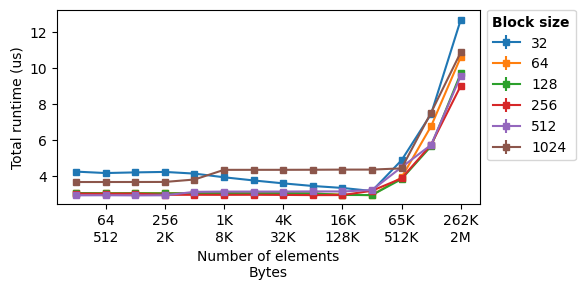

In [1632]:
average = False; figname = f"../../images/gpu_updatestats_mb{('_avg' if average else '')}.pdf"

selected_bulksize = 32768*8
selected_blocksize = 256
unit = "us"
rep  = trbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(trbm_mean["time_unit"].values[0], unit) / rep

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

for bsi, bs in enumerate(trbm_mean["blocksize"].unique()):
    arg = (trbm_mean["blocksize"] == bs)
    avg = trbm_mean.loc[arg]
    std = trbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], 
                 avg["real_time"]  * norm / (avg["bulksize"] if average else 1),
                 yerr=std["real_time"] * norm / (avg["bulksize"] if average else 1),
                 label=f"{bs}", **bm_style)

# plt.plot(selected_size, 
#          avg.loc[avg["nbins"] == selected_size]["real_time"] * norm,
#          'ok', ms=14, markerfacecolor="None",)

plt.xlabel("Number of elements\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
plt.ylabel(f"{('Average' if average else 'Total')} runtime ({unit})")
# plt.yscale("symlog")
# plt.ylim([3.5, 8])

plt.tight_layout()
fig.legend(title="Block size",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(0.97, 0.7), ncols=1)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

## Calibration

[2.27171755e-02 2.82317569e+03]


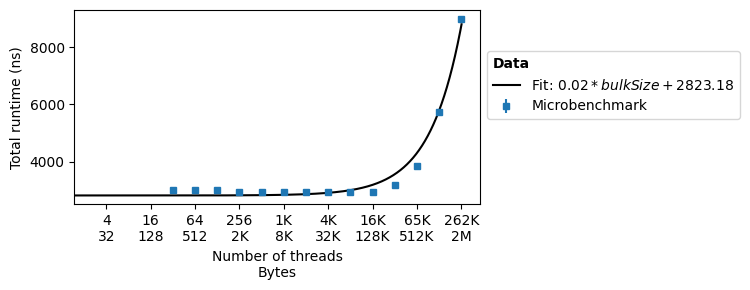

In [1633]:
figname = "../../images/gpu_updatestats_calib.pdf"

def T_gpu_usb(bulksize, a, b):
    # return a*np.array(bulksize) + b
    # return 1/(a*bulksize+b) + c
    return a*bulksize+b
    # return a * np.log(b * bulksize) + c
    # return a * np.exp(-b * bulksize) + c
    # return a * pow(b, bulksize) + c
    
selected_bulksize = 32768*8
selected_blocksize = 256
unit = "ns"
rep  = trbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# microbenchmark data
arg = (trbm_mean["blocksize"] == selected_blocksize) 
avg = trbm_mean.loc[arg] 
std = trbm_std.loc[arg]
norm = unit_to_unit_factor(trbm_mean["time_unit"].values[0], unit) / rep / (avg["bulksize"] if average else 1)
plt.errorbar(avg["bulksize"], 
             avg["real_time"]  * norm,
             yerr=std["real_time"] * norm,
             label=f"Microbenchmark", ls="", **bm_style)

## fit line
x = np.linspace(0, pow(2, 18)+1024, 100000)
Tusb_popt, pcov = scipy.optimize.curve_fit(T_gpu_usb, avg["bulksize"], 
                                      avg["real_time"]  * norm, 
                                      # p0=[6784,24,0], 
                                      # method='trf',
                                      maxfev=100000)
# plt.plot(x, T_gpu_usb(x, *Tusb_popt), 'k-', label=r"Fit: ${} * bulkSize^{{{}}} {}$".format(*[round(r, 2) for r in Tusb_popt]))
plt.plot(x, T_gpu_usb(x, *Tusb_popt), 'k-', label=r"Fit: ${} * bulkSize + {}$".format(*[round(r, 2) for r in Tusb_popt]))
print(Tusb_popt)


# plt.plot(x, T_gpu_usb(x, 6000, 24, 0), 'b-', label="Fitted Curve")
# plt.plot(x, T_gpu_usb(x, avg["real_time"].mean()  * norm, 24, 0), 'b-', label="Fitted Curve")

##### Calibration ######
# T_gpu_usb = np.mean(avg["real_time"].loc[avg["bulksize"] > 4096] 
#                     / avg["bulksize"].loc[avg["bulksize"] > 4096])  * norm
# plt.plot(x, np.repeat(T_gpu_usb, len(x)), 'k-', label="Calibration")

plt.xlabel("Number of threads\nBytes")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"))
if average: plt.ylabel(f"Average runtime\nper thread ({unit})")
else: plt.ylabel(f"Total runtime ({unit})")
# plt.yscale("symlog")
# plt.yscale("log", base=2)
# plt.ylim([0, 0.2*norm])

plt.tight_layout()
fig.legend(title="Data",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='center left', bbox_to_anchor=(0.97, 0.7), ncols=1)
plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show();

In [1634]:
bks = 32768
bls = 256
threads, blocks = transformreduce_geometry(bks, bls)
print(threads, blocks)
s = blocks
while s > 1:
    threads, blocks = transformreduce_geometry(s, bls)
    print(threads, blocks)
    next_s = int((s + (threads * 2 - 1)) / (threads * 2))
    s = next_s;

256 64
64 1


## Validation

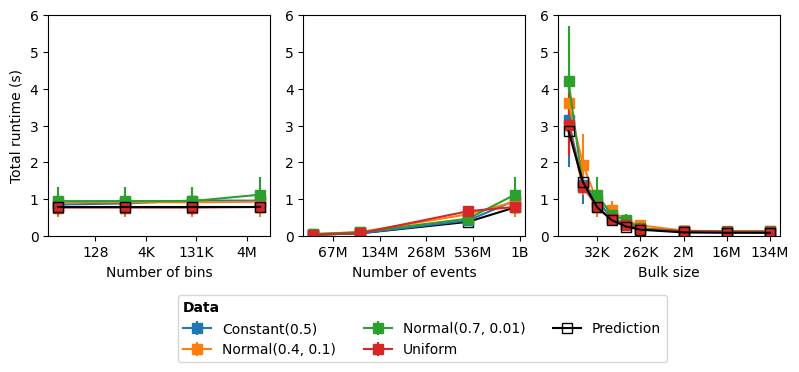

In [1635]:
figname="../../images/gpu_updatestats_validation_das6.pdf"

def next_power_of_2(x):
    return 1 if x == 0 else 2**np.ceil(np.log2(x))
def transformreduce_geometry(bulksize, blocksize):
    threads =  next_power_of_2((bulksize + 1) / 2) if bulksize < blocksize * 2 else blocksize
    blocks = (bulksize + (threads * 2 - 1)) / (threads * 2)
    return int(threads), int(blocks)

selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_blocksize = 256
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(vd_unique_distributions)
selected_edges = False
unit="s"
norm = unit_to_unit_factor("ns", unit) 
hmax = 6

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(131)

for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, 
           selected_bulksize, selected_edges, "UpdateStats")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nbins, avg["Total Time (ns)"]* norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                   )

## Prediction
blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
pred = np.repeat((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize)) # final reduction
                 * unit_to_unit_factor("ns", "s"), len(vd_unique_nbins))
ax.errorbar(vd_unique_nbins, 
            pred,             label="Prediction", **pred_style

)
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])
plt.ylabel("Total runtime (s)")

#####################
ax = plt.subplot(132)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, 
           selected_bulksize, selected_edges,  "UpdateStats")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_nvals, avg["Total Time (ns)"] * norm, 
                     yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )
    
## Prediction
blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
pred = ((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize) # main reduction
         + T_gpu_usb(blocks, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize)) # final reduction
         * unit_to_unit_factor("ns", "s"))
ax.plot(vd_unique_nvals, pred, label="Prediction", **pred_style)
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])

#####################
ax = plt.subplot(133)
for di,distr in enumerate(selected_distr):
    arg = (selected_env, selected_gpu, distr, selected_nvals, selected_nbins, 
           vd_unique_bulksize, selected_edges,  "UpdateStats")
    avg = gp_kernels.mean().loc[arg]
    std = gp_kernels.std().loc[arg]
    
    p = ax.errorbar(vd_unique_bulksize, avg["Total Time (ns)"] * norm, 
                    yerr=std["Total Time (ns)"]* norm, 
                    label=f"{map_distr_name(distr)}".title(),
                    **vd_style,
                )

## Prediction
blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
pred = ((T_gpu_usb(vd_unique_bulksize, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize) # main reduction
         + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize)) # final reduction
         * unit_to_unit_factor("ns", "s"))
ax.errorbar(vd_unique_bulksize, pred, 
            label="Prediction", **pred_style
)
# observ = avg["tstats"].values
# print("MAE:", mae(pred, observ))
# print("R2:", r2(pred, observ) * 100)

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, hmax])

##############
fig.tight_layout()
plt.legend(title="Data", loc='lower left',  bbox_to_anchor=(-1.75, -.6), ncols=3,
           alignment="left", title_fontproperties={'weight':'bold'})

plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

# Memory Transfers

## Design

## Calibration

## Validation

# Total Validation

## Total vs. inner

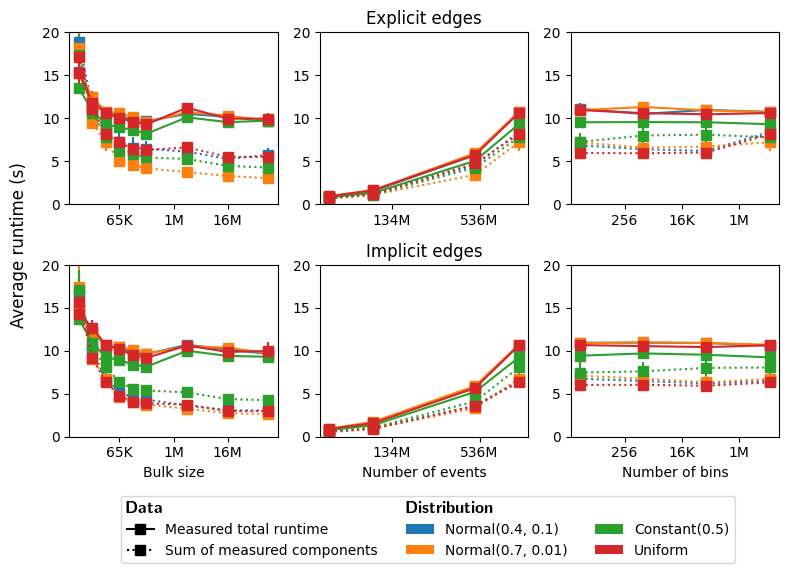

In [1636]:
figname ="../../images/gpu_total_vs_inner_das6.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
selected_edges = True
unit="s"
norm = unit_to_unit_factor("ns", "s") 
include_api = True

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_bulksize, ttotal_avg, yerr=ttotal_std, **vd_style, 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"] * include_api
            tkernels_std = gp_kernels.std().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tmemop_std = gp_memops.std().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            tapi_std =  gp_api.std().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
            p = plt.errorbar(vd_unique_bulksize, 
                             (tkernels + tmemop + tapi) * norm, 
                              yerr=(tkernels_std + tmemop_std + tapi_std) * norm, 
                             **sum_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Bulk size")
        
    plt.ylim([0,20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nvals, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"] * include_api
            tkernels_std = gp_kernels.std().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tmemop_std = gp_memops.std().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            tapi_std =  gp_api.std().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
            p = plt.errorbar(vd_unique_nvals, 
                             (tkernels + tmemop + tapi) * norm, 
                             yerr=(tkernels_std + tmemop_std + tapi_std) * norm, 
                             **sum_style, color=p[0].get_color(),                             )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of events")
        
    plt.ylim([0,20])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    ax.plot(0,0, label="Measured total runtime", c="k", **vd_style)
    plt.plot(0,0, label="Sum of measured components", c="k", **sum_style)
    
    for distr in vd_unique_distributions:
        arg = selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nbins, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Sum of inner
        if distr in kernel_buf["distribution"].values:
            tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]  * include_api
            tkernels_std = gp_kernels.std().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tmemop_std = gp_memops.std().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
            tapi_std =  gp_api.std().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"] 
            p = plt.errorbar(vd_unique_nbins, 
                             (tkernels + tmemop + tapi) * norm, 
                            yerr=(tkernels_std + tmemop_std + tapi_std) * norm, 
                            **sum_style, color=p[0].get_color(), 
                            )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))


    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0,20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')

plt.tight_layout()
plt.savefig(figname, format="pdf", bbox_inches='tight')

## Runtime

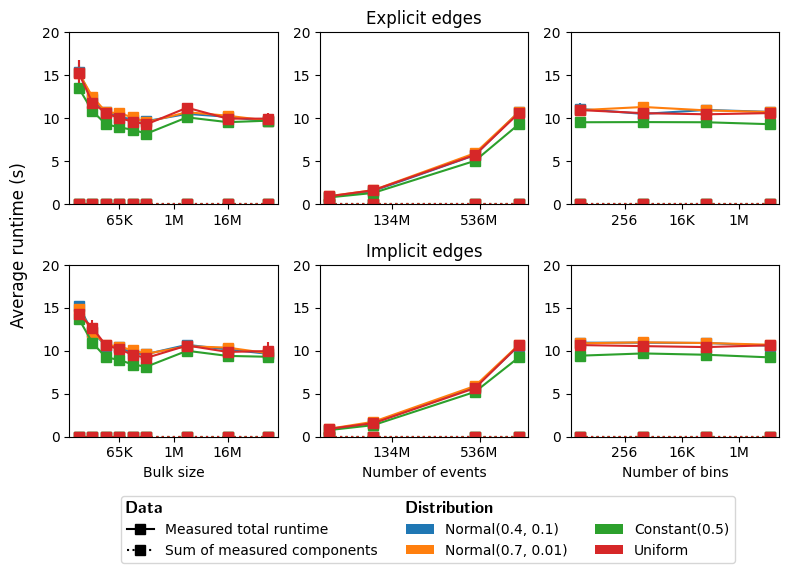

In [1637]:
figname ="../../images/gpu_validation_das6.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
edg = True
unit="s"
norm = unit_to_unit_factor("ns", "s") 

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_bulksize, ttotal_avg, yerr=ttotal_std, **vd_style, 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction
        blocks = (vd_unique_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = ((T_gpu_usb(vd_unique_bulksize, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/vd_unique_bulksize)) # final reduction
                 * unit_to_unit_factor("ns", "s"))
        T_abc = 0
        T_fb = 0
        p = plt.errorbar(vd_unique_bulksize, 
                         (T_usb + T_abc + T_fb) * norm, 
                         **sum_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Bulk size")
        
    plt.ylim([0,20])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nvals, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction       
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = ((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (vd_unique_nvals/selected_bulksize)) # final reduction
                 * unit_to_unit_factor("ns", "s"))
        T_abc = 0
        T_fb = 0
        p = plt.errorbar(vd_unique_nvals, 
                         (T_usb + T_abc + T_fb) * norm, 
                         **sum_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of events")
        
    plt.ylim([0,20])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    ax.plot(0,0, label="Measured total runtime", c="k", **vd_style)
    plt.plot(0,0, label="Sum of measured components", c="k", **sum_style)
    
    for distr in vd_unique_distributions:
        arg = selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(vd_unique_nbins, ttotal_avg, yerr=ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction
        blocks = (selected_bulksize + (selected_blocksize * 2 - 1)) / (selected_blocksize * 2)
        T_usb = np.repeat((T_gpu_usb(selected_bulksize, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize) # main reduction
                 + T_gpu_usb(blocks, *Tusb_popt) * 4 * (selected_nvals/selected_bulksize)) # final reduction
                 * unit_to_unit_factor("ns", "s"), len(vd_unique_nbins))
        T_abc = 0
        T_fb = 0
        p = plt.errorbar(vd_unique_nbins, 
                         (T_usb + T_abc + T_fb) * norm, 
                         **sum_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))


    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0,20])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Average runtime (s)')

plt.tight_layout()
plt.savefig(figname, format="pdf", bbox_inches='tight')

In [1638]:
vd_unique_bulksize

array([     8192,     16384,     32768,     65536,    131072,    262144,
         2097152,  16777216, 134217728])

## Speedups

In [1639]:
cpu_validation_results = "../cpu-sequential/das6-cpu/validation" 
cpu_validation_df = pd.read_csv(cpu_validation_results)
cpu_validation_df["nvals"] =  cpu_validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
cpu_validation_df["distribution"] =  cpu_validation_df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(cpu_validation_df, "tfindbin", np.float64)
convert_to_type(cpu_validation_df, "tfill", np.float64)
convert_to_type(cpu_validation_df, "tstats", np.float64)
convert_to_type(cpu_validation_df, "edges", np.bool_)
del cpu_validation_df["input"]
cpu_validation_df
cpu_gp_vd = cpu_validation_df.groupby(["env", "distribution", "nvals", "nbins", "bulksize", "edges"])
cpu_gp_vd.mean()

iter  tfindbin  tfill  \
env distribution nvals        nbins    bulksize edges                          
CPU constant-0.5 5.000000e+07 10       1        False   2.0       0.0    0.0   
                                                True    2.0       0.0    0.0   
                                       8        False   2.0       0.0    0.0   
                                                True    2.0       0.0    0.0   
                                       64       False   2.0       0.0    0.0   
...                                                     ...       ...    ...   
    uniform      1.000000e+09 10000000 4096     True    2.0       0.0    0.0   
                                       32768    False   2.0       0.0    0.0   
                                                True    2.0       0.0    0.0   
                                       262144   False   2.0       0.0    0.0   
                                                True    2.0       0.0    0.0   

                                                       tstats      ttotal  
env distribution nvals        nbins    bulksize edges                      
CPU constant-0.5 5.000000e+07 10       1        False     0.0    5.855866  
                                                True      0.0    6.138094  
                                       8        False     0.0    2.390566  
                                                True      0.0    2.693355  
                                       64       False     0.0    1.369318  
...                                                       ...         ...  
    uniform      1.000000e+09 10000000 4096     True      0.0  571.924609  
                                       32768    False     0.0   64.174634  
                                                True      0.0  573.630570  
                                       262144   False     0.0   66.130768  
                                                True      0.0  571.952656  

[896 rows x 5 columns]

In [1640]:
cpu_validation_df["bulksize"].unique()

array([     1,      8,     64,    512,   4096,  32768, 262144])

In [1641]:
cpgpu_unique_bulksize = np.array([v for v in vd_unique_bulksize if v in cpu_validation_df["bulksize"].unique()])

KeyError: 8192

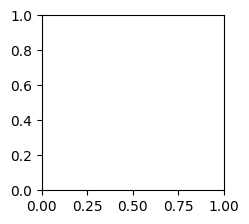

In [1642]:
figname ="../../images/validation_speedups_das6.pdf"
selected_env = "CUDA" 
selected_gpu = "A4000" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = vd_unique_distributions
edg = True
unit="s"
norm = norm 

fig = plt.figure(figsize=(8, 5))

for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi*3+1)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"].values
        ttotal_std = gp_vd.std().loc[arg]["ttotal"].values
        carg = "CPU", distr, selected_nvals, selected_nbins, vd_unique_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        cttotal_std = cpu_gp_vd.std().loc[carg]["ttotal"].values
        
        p = plt.errorbar(vd_unique_bulksize, cttotal_avg/ttotal_avg, 
                         yerr=cttotal_std/ttotal_std, **vd_style, 
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction
        # if distr in kernel_buf["distribution"].values:
        #     tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
        #     tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["bulksize"]).sum()["Total Time (ns)"]
        #     p = plt.errorbar(vd_unique_bulksize, 
        #                      (tkernels + tmemop + tapi) * norm, 
        #                      **sum_style, color=p[0].get_color(), )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
        
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Bulk size")
        
    plt.ylim([0,70 - (not edg) * 60])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+2)
    
    for distr in vd_unique_distributions:
        # Total
        arg = selected_env, selected_gpu, distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"].values
        ttotal_std = gp_vd.std().loc[arg]["ttotal"].values
        carg = "CPU", distr, vd_unique_nvals, selected_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        cttotal_std = cpu_gp_vd.std().loc[carg]["ttotal"].values
        p = plt.errorbar(vd_unique_nvals, cttotal_avg/ttotal_avg, yerr=cttotal_std/ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction       
        # if distr in kernel_buf["distribution"].values:
        #     tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
        #     tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
        #     tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nvals"]).sum()["Total Time (ns)"]
        #     p = plt.errorbar(vd_unique_nvals, 
        #                      (tkernels + tmemop + tapi) * norm, 
        #                      **sum_style, color=p[0].get_color(),                             )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of events")
        
    plt.ylim([0,70 - (not edg) * 60])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi*3+3)
    
    # Legend Labels
    ax.plot(0,0, label="Measured speedup", c="k", **vd_style)
    plt.plot(0,0, label="Prediction", **pred_style)
    
    for distr in vd_unique_distributions:
        arg = selected_env, selected_gpu, distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"].values
        ttotal_std = gp_vd.std().loc[arg]["ttotal"].values
        carg = "CPU",  distr, selected_nvals, vd_unique_nbins, selected_bulksize, edg
        cttotal_avg = cpu_gp_vd.mean().loc[carg]["ttotal"].values
        cttotal_std = cpu_gp_vd.std().loc[carg]["ttotal"].values
        p = plt.errorbar(vd_unique_nbins, cttotal_avg/ttotal_avg, yerr=cttotal_std/ttotal_std, **vd_style,
                     # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                     # label=f"{distr} total"
                    )
    
        # Prediction
        # if distr in kernel_buf["distribution"].values:
        #     tkernels = gp_kernels.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
        #     tmemop = gp_memops.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"]
        #     tapi =  gp_api.mean().loc[arg].reset_index().groupby(["nbins"]).sum()["Total Time (ns)"] 
        #     p = plt.errorbar(vd_unique_nbins, 
        #                      (tkernels + tmemop + tapi) * norm, 
        #                     **sum_style, color=p[0].get_color(), 
        #                     )
        
        # Legend Labels
        ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                     facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))


    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    if edi == 1:
        plt.xlabel("Number of bins")

    plt.ylim([0,70 - (not edg) * 60])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(hndls, lbls, loc='lower left', bbox_to_anchor=(0.15, -0.15), ncols=3,
                    handler_map={str: LegendTitle({'fontsize':12})})

fig.supylabel('Speedup)')

plt.tight_layout()
# plt.savefig(figname, format="pdf", bbox_inches='tight')